In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd  
import numpy as np
import os
import gc
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import matplotlib.image as mpimg
# from scipy.misc import toimage
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import datetime
import xgboost as xgb

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier 
from datetime import datetime, date
from matplotlib.pyplot import imread
from matplotlib.pyplot import figure, imshow, axis


In [5]:
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 160)

In [6]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
# Функция возвращает рейтинг в общем списке игр за последние (ins=10) игр и добовляет (mem=0.05) от суммированого за веесь 
# предидущий период

def fn_data_trans(data, ins=10, mem=0.05):
    team1 = data['team_1'].unique()
    data[['team10_1', 'team10_2', 'rating_1_total', 'rating_2_total']] = 0.0
    for j in team1:
        z = [0.0 for i in range(ins)]
        n = 0.0
        in_10 = 0.0
        in_20 = 0.0
        for i in range(data.shape[0]):
            if data['team_1'][i] == j:
                n = (n + data['rating_team_1'][i])
                data['rating_1_total'][i] = n
                z.append(i)
                in_10 = z.pop(0)
                if in_10 == 0.0:
                    data['team10_1'][i] = data['rating_1_total'][i]
                else:
                    if data['team_1'][in_10] == j:
                        ad_1 = data['rating_1_total'][in_10]
                    else:
                        ad_1 = data['rating_2_total'][in_10]
                    data['team10_1'][i] = (data['rating_1_total'][i] - ad_1 * ((1 - mem)/1))
                i1 = i
            if data['team_2'][i] == j:
                n = (n + data['rating_team_2'][i])
                data['rating_2_total'][i] = n 
                z.append(i)
                in_20 = z.pop(0)
                if in_20 == 0.0:
                    data['team10_2'][i] = data['rating_2_total'][i]    
                else:
                    if data['team_2'][in_20] == j:
                        ad_2 = data['rating_2_total'][in_20]
                    else:
                        ad_2 = data['rating_1_total'][in_20]
                    data['team10_2'][i] = (data['rating_2_total'][i] - ad_2 * ((1 - mem)/1))
                i2 = i        
        rating_tot = n
        if i1 > i2:
            rating_act = data['team10_1'][i1]
        else: 
            rating_act = data['team10_2'][i2]
    return data

In [8]:
# функция сортирующая игру, результаты, рейтинг одной команды со всеми остальными по столбцам

def fn_rename_total(df, name_1):
    for i in range(len(df)):
        if (df['team_1'][df.index[i]] != name_1 and df['team_2'][df.index[i]] != name_1):
            return "error fn_rename"
        
        if df['team_1'][df.index[i]] == name_1:
            pass
        if df['team_2'][df.index[i]] == name_1:
            df['team_1'][df.index[i]], df['team_2'][df.index[i]] = df['team_2'][df.index[i]], df['team_1'][df.index[i]]
            df['p_1'][df.index[i]], df['p_2'][df.index[i]] = df['p_2'][df.index[i]], df['p_1'][df.index[i]]
            df['score_1'][df.index[i]], df['score_2'][df.index[i]] = df['score_2'][df.index[i]], df['score_1'][df.index[i]]
            df['rating_team_1'][df.index[i]], df['rating_team_2'][df.index[i]] = df['rating_team_2'][df.index[i]], df['rating_team_1'][df.index[i]]
            df['rating_1_total'][df.index[i]], df['rating_2_total'][df.index[i]] = df['rating_2_total'][df.index[i]], df['rating_1_total'][df.index[i]]
            df['team10_1'][df.index[i]], df['team10_2'][df.index[i]] = df['team10_2'][df.index[i]], df['team10_1'][df.index[i]]
    df['team_score'] = df['score_1']
    return df

In [9]:
# функция добавления target и рейтинга между двумя командами
# shift_target=1 - сдвиг предсказания на количество игр, 1 - предсказание следующей игры (2 - через одну и т.д.) 

def fn_target_one_total_local_rating(data, shift_target=1):
    team_one = data['team_2'].unique()
    data['target'] = 0
    data['local_rating_1'] = 0.0
    data['local_rating_2'] = 0.0
    for j in team_one:
        z = [0 for i in range(shift_target)]
        n = 0
        in_10 = 0
        n_loc1, n_loc2 = 0, 0
        for i in data.index:
            if data['team_2'][i] == j:
                data['local_rating_1'][i] = (data['rating_team_1'][i] + n_loc1)
                n_loc1 = data['local_rating_1'][i]
                data['local_rating_2'][i] = (data['rating_team_2'][i] + n_loc2)
                n_loc2 = data['local_rating_1'][i]
                z.append(i)
                in_1 = z.pop(0)
                if n >= shift_target:
                    data['target'][in_1] = data['team_score'][i]
                n =+ 1           
    return data

### извлечение подготовленных данных из сохраненных сетов:

In [10]:
# data_common_index = pd.read_csv('data_common_index.csv').head()
data_common = pd.read_csv('data_common.csv')
data_trans = fn_data_trans(data_common, 10, 0.05)
df_Boston_Celtics = data_trans.loc[data_trans.values == 'Boston Celtics']
df_Boston_Celtics_total = fn_rename_total(df_Boston_Celtics, 'Boston Celtics')
df_Boston_Celtics_total_loc = fn_target_one_total_local_rating(df_Boston_Celtics_total)
df_Boston_Celtics_total_loc.to_csv('df_Boston_Celtics_total_loc.csv', index=False)
df_Boston_Celtics_total_loc.to_csv('df_Boston_Celtics_total_loc_index.csv', index=True)
df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc.csv')
df_Boston_loc.tail()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
716,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,1,1,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0,1.141091,0.954944
717,2019-04-04 02:30:00,Boston Celtics,Miami Heat,112,102,1,1,0,1,0,0.196078,-0.178571,39.971187,56.190320,1.769690,3.061785,2019,4,14,3,1.337169,0.962519
718,2019-06-04 03:00:00,Boston Celtics,Indiana Pacers,117,97,1,1,0,1,0,0.412371,-0.341880,40.383558,42.230181,2.039561,2.250653,2019,6,23,1,1.733401,0.979150
719,2019-08-04 02:30:00,Boston Celtics,Orlando Magic,108,116,1,0,1,0,0,-0.137931,0.148148,40.245627,-27.024123,2.051630,0.279652,2019,8,31,6,5.421197,5.707276
720,2019-10-04 02:00:00,Boston Celtics,Washington Wizards,116,110,1,1,0,1,0,0.109091,-0.103448,40.354718,-7.849760,2.209026,-1.158776,2019,10,40,4,2.942406,2.729867


In [11]:
df_Indiana_loc = pd.read_csv('df_Indiana_Pacers_total_loc')
df_Indiana_loc.loc[df_Indiana_loc.values == 'Miami Heat']

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
11,2010-11-23 03:30:00,Indiana Pacers,Miami Heat,93,77,1,1,0,1,0,0.415584,-0.344086,1.173537,2.673561,1.173537,2.625495,2010,11,47,1,0.415584,-0.344086
48,2011-09-02 03:30:00,Indiana Pacers,Miami Heat,112,117,1,0,1,0,0,-0.085470,0.089286,0.346682,9.828909,0.530981,1.259159,2011,9,35,4,0.330114,0.504870
52,2011-02-16 03:00:00,Indiana Pacers,Miami Heat,103,110,1,0,1,0,0,-0.127273,0.135922,0.572062,10.198591,1.250029,2.184733,2011,2,7,2,0.202842,0.466037
87,2012-05-01 04:30:00,Indiana Pacers,Miami Heat,83,118,1,0,1,0,0,-0.593220,0.843373,-0.710362,16.554274,0.129699,3.288795,2012,5,18,1,-0.390379,1.046215
109,2012-02-15 04:00:00,Indiana Pacers,Miami Heat,90,105,1,0,1,0,0,-0.285714,0.333333,0.760702,20.438154,0.374348,2.741129,2012,2,7,2,-0.676093,-0.057045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,2018-11-01 03:00:00,Indiana Pacers,Miami Heat,106,114,1,0,1,0,1,-0.140351,0.150943,32.802926,52.520010,0.134040,0.341836,2018,11,44,3,0.804866,1.096160
630,2018-03-26 00:00:00,Indiana Pacers,Miami Heat,113,107,2,1,0,1,1,0.084112,-0.079646,34.933033,54.124875,0.459549,1.289315,2018,3,13,0,0.888978,0.725220
651,2018-10-11 04:00:00,Indiana Pacers,Miami Heat,110,102,1,1,0,1,1,0.156863,-0.145455,36.095752,55.163618,0.449718,0.372645,2018,10,41,3,1.045841,0.743524
653,2018-11-17 03:00:00,Indiana Pacers,Miami Heat,99,91,1,1,0,1,1,0.175824,-0.161616,36.062880,54.980254,0.347839,0.150485,2018,11,46,5,1.221665,0.884225


In [12]:
df_Boston_loc#.tail()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,1,1,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2,0.200000,-0.181818
1,2010-10-28 03:00:00,Boston Celtics,Cleveland Cavaliers,87,95,1,0,1,0,1,-0.168421,0.183908,0.031579,0.183908,0.031579,0.183908,2010,10,43,3,-0.168421,0.183908
2,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,1,1,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5,0.079208,-0.076190
3,2010-03-11 02:30:00,Boston Celtics,Detroit Pistons,109,86,1,1,0,1,0,0.534884,-0.422018,0.645671,-0.698492,0.645671,-0.698492,2010,3,10,3,0.534884,-0.422018
4,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,1,1,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6,0.044118,-0.042857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,1,1,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0,1.141091,0.954944
717,2019-04-04 02:30:00,Boston Celtics,Miami Heat,112,102,1,1,0,1,0,0.196078,-0.178571,39.971187,56.190320,1.769690,3.061785,2019,4,14,3,1.337169,0.962519
718,2019-06-04 03:00:00,Boston Celtics,Indiana Pacers,117,97,1,1,0,1,0,0.412371,-0.341880,40.383558,42.230181,2.039561,2.250653,2019,6,23,1,1.733401,0.979150
719,2019-08-04 02:30:00,Boston Celtics,Orlando Magic,108,116,1,0,1,0,0,-0.137931,0.148148,40.245627,-27.024123,2.051630,0.279652,2019,8,31,6,5.421197,5.707276


In [13]:
data_common = pd.read_csv('data_common.csv')
data_trans = fn_data_trans(data_common, 10, 0.05)
df_Los_Angeles_Clippers = data_trans.loc[data_trans.values == 'Los Angeles Clippers']#Los_Angeles_Clippers
df_Los_Angeles_Clippers_total = fn_rename_total(df_Los_Angeles_Clippers, 'Los Angeles Clippers')
df_Los_Angeles_Clippers_total_loc = fn_target_one_total_local_rating(df_Los_Angeles_Clippers_total)
df_Los_Angeles_Clippers_total_loc.to_csv('df_Los_Angeles_Clippers_total_loc.csv', index=False)
df_Los_Angeles_Clippers_total_loc.to_csv('df_Los_Angeles_Clippers_total_loc_index.csv', index=True)
df_Los_Angeles_loc = pd.read_csv('df_Los_Angeles_Clippers_total_loc.csv')
df_Los_Angeles_loc.tail()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
717,2019-01-04 05:30:00,Los Angeles Clippers,Memphis Grizzlies,113,96,1,1,0,1,0,0.354167,-0.300885,61.498282,18.158249,4.038029,0.184947,2019,1,1,4,2.977178,2.322127
718,2019-04-04 05:30:00,Los Angeles Clippers,Houston Rockets,103,135,1,0,1,0,0,-0.474074,0.621359,61.024208,62.379128,3.883155,5.864133,2019,4,14,3,1.630028,2.725461
719,2019-06-04 05:30:00,Los Angeles Clippers,Los Angeles Lakers,117,122,1,0,1,0,0,-0.081967,0.085470,60.942240,-23.738908,3.691270,-1.077457,2019,6,23,1,7.208803,7.376241
720,2019-08-04 03:30:00,Los Angeles Clippers,Golden State Warriors,104,131,1,0,1,0,0,-0.412214,0.519231,60.530027,85.448042,3.229918,6.844399,2019,8,31,6,-2.738059,-1.806615
721,2019-11-04 05:30:00,Los Angeles Clippers,Utah Jazz,143,137,2,1,0,1,0,0.065693,-0.062937,60.595720,26.631837,3.191025,4.104052,2019,11,45,0,1.313952,1.185321


# Подготовка данных. 
#### можно пропустить, сохранены датасеты.

In [14]:
df_10 = pd.read_csv('drive-download-20200503T144508Z-001/10`11 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [15]:
df_11 = pd.read_csv('drive-download-20200503T144508Z-001/11`12 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [16]:
df_12 = pd.read_csv('drive-download-20200503T144508Z-001/12`13 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [17]:
df_13 = pd.read_csv('drive-download-20200503T144508Z-001/13`14 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [18]:
df_14 = pd.read_csv('drive-download-20200503T144508Z-001/14`15 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [19]:
df_15 = pd.read_csv('drive-download-20200503T144508Z-001/15`16 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [20]:
df_16 = pd.read_csv('drive-download-20200503T144508Z-001/16`17 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [21]:
df_17 = pd.read_csv('drive-download-20200503T144508Z-001/17`18 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [22]:
df_18 = pd.read_csv('drive-download-20200503T144508Z-001/18`19 regular season.txt', sep='|',
                 names=['date','team','score'],
                )

In [23]:
df_18#.head()

,date,team,score
0,17.10.2018 03:00,Бостон Селтикс – Филадельфия Сиксерс,105 : 87
1,17.10.2018 05:30,Голден Стэйт Уорриорз – Оклахома-Сити Тандер,108 : 100
2,18.10.2018 02:00,Орландо Мэджик – Майами Хит,104 : 101
3,18.10.2018 02:00,Индиана Пэйсерс – Мемфис Гриззлиз,111 : 83
4,18.10.2018 02:00,Детройт Пистонс – Бруклин Нетс,103 : 100
...,...,...,...
1225,11.04.2019 03:00,Бруклин Нетс – Майами Хит,113 : 94
1226,11.04.2019 03:00,Атланта Хоукс – Индиана Пэйсерс,134 : 135
1227,11.04.2019 05:30,Портленд Трэйл Блэйзерс – Сакраменто Кингз,136 : 131
1228,11.04.2019 05:30,Лос-Анджелес Клипперс – Юта Джаз,143 : 137 ОТ


In [24]:
df_10_18 = pd.concat([df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18], ignore_index=True)
df_10_18

,date,team,score
0,27.10.2010 03:30,Бостон Селтикс – Майами Хит,88 : 80
1,27.10.2010 06:00,Портленд Трэйл Блэйзерс – Финикс Санз,106 : 92
2,27.10.2010 06:30,Лос-Анджелес Лейкерс – Хьюстон Рокетс,112 : 110
3,28.10.2010 03:00,Нью-Джерси Нетс – Детройт Пистонс,101 : 98
4,28.10.2010 03:00,Кливленд Кавальерс – Бостон Селтикс,95 : 87
...,...,...,...
10824,11.04.2019 03:00,Бруклин Нетс – Майами Хит,113 : 94
10825,11.04.2019 03:00,Атланта Хоукс – Индиана Пэйсерс,134 : 135
10826,11.04.2019 05:30,Портленд Трэйл Блэйзерс – Сакраменто Кингз,136 : 131
10827,11.04.2019 05:30,Лос-Анджелес Клипперс – Юта Джаз,143 : 137 ОТ


In [25]:
df = df_10_18.copy() 

In [26]:
df['team']

0                        Бостон Селтикс – Майами Хит 
1              Портленд Трэйл Блэйзерс – Финикс Санз 
2              Лос-Анджелес Лейкерс – Хьюстон Рокетс 
3                  Нью-Джерси Нетс – Детройт Пистонс 
4                Кливленд Кавальерс – Бостон Селтикс 
                             ...                     
10824                      Бруклин Нетс – Майами Хит 
10825                Атланта Хоукс – Индиана Пэйсерс 
10826     Портленд Трэйл Блэйзерс – Сакраменто Кингз 
10827               Лос-Анджелес Клипперс – Юта Джаз 
10828         Денвер Наггетс – Миннесота Тимбервулвз 
Name: team, Length: 10829, dtype: object

In [27]:
new_df = df['score'].str.split(':', expand=True)
new_df.columns=['p_1','2']
new_df.head()

,p_1,2
0,88,80
1,106,92
2,112,110
3,101,98
4,95,87


In [28]:
new_df2 = new_df['2'].str.split(' ', expand=True)
new_df2.columns=['0_','p_2','ОТ']
new_df2.head()

,0_,p_2,ОТ
0,,80,None
1,,92,None
2,,110,None
3,,98,None
4,,87,None


In [29]:
new_df1 = df['team'].str.split('–', expand=True)
new_df1.columns=['team_1','team_2']
new_df1

,team_1,team_2
0,Бостон Селтикс,Майами Хит
1,Портленд Трэйл Блэйзерс,Финикс Санз
2,Лос-Анджелес Лейкерс,Хьюстон Рокетс
3,Нью-Джерси Нетс,Детройт Пистонс
4,Кливленд Кавальерс,Бостон Селтикс
...,...,...
10824,Бруклин Нетс,Майами Хит
10825,Атланта Хоукс,Индиана Пэйсерс
10826,Портленд Трэйл Блэйзерс,Сакраменто Кингз
10827,Лос-Анджелес Клипперс,Юта Джаз


In [30]:
final_df = pd.concat([df, new_df1, new_df['p_1'], new_df2['p_2'], new_df2['ОТ']],axis=1)
final_df = final_df.drop(['team','score'], axis=1)

final_df.head()

,date,team_1,team_2,p_1,p_2,ОТ
0,27.10.2010 03:30,Бостон Селтикс,Майами Хит,88,80,None
1,27.10.2010 06:00,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,None
2,27.10.2010 06:30,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,None
3,28.10.2010 03:00,Нью-Джерси Нетс,Детройт Пистонс,101,98,None
4,28.10.2010 03:00,Кливленд Кавальерс,Бостон Селтикс,95,87,None


In [31]:
data = final_df.copy()

In [32]:
data.head()

,date,team_1,team_2,p_1,p_2,ОТ
0,27.10.2010 03:30,Бостон Селтикс,Майами Хит,88,80,None
1,27.10.2010 06:00,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,None
2,27.10.2010 06:30,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,None
3,28.10.2010 03:00,Нью-Джерси Нетс,Детройт Пистонс,101,98,None
4,28.10.2010 03:00,Кливленд Кавальерс,Бостон Селтикс,95,87,None


In [33]:
data['ОТ'].fillna(1, inplace=True)
data.loc[data['ОТ']=='ОТ', 'ОТ'] = 2
data

,date,team_1,team_2,p_1,p_2,ОТ
0,27.10.2010 03:30,Бостон Селтикс,Майами Хит,88,80,1
1,27.10.2010 06:00,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1
2,27.10.2010 06:30,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1
3,28.10.2010 03:00,Нью-Джерси Нетс,Детройт Пистонс,101,98,1
4,28.10.2010 03:00,Кливленд Кавальерс,Бостон Селтикс,95,87,1
...,...,...,...,...,...,...
10824,11.04.2019 03:00,Бруклин Нетс,Майами Хит,113,94,1
10825,11.04.2019 03:00,Атланта Хоукс,Индиана Пэйсерс,134,135,1
10826,11.04.2019 05:30,Портленд Трэйл Блэйзерс,Сакраменто Кингз,136,131,1
10827,11.04.2019 05:30,Лос-Анджелес Клипперс,Юта Джаз,143,137,2


In [34]:
data['team_1'].unique()

array([' Бостон Селтикс ', ' Портленд Трэйл Блэйзерс ',
       ' Лос-Анджелес Лейкерс ', ' Нью-Джерси Нетс ',
       ' Кливленд Кавальерс ', ' Филадельфия Сиксерс ',
       ' Торонто Рэпторс ', ' Нью-Орлеан Хорнетс ', ' Мемфис Гриззлиз ',
       ' Оклахома-Сити Тандер ', ' Миннесота Тимбервулвз ',
       ' Даллас Маверикс ', ' Сан-Антонио Спёрс ', ' Денвер Наггетс ',
       ' Лос-Анджелес Клипперс ', ' Голден Стэйт Уорриорз ',
       ' Орландо Мэджик ', ' Юта Джаз ', ' Шарлотт Бобкэтс ',
       ' Детройт Пистонс ', ' Майами Хит ', ' Финикс Санз ',
       ' Атланта Хоукс ', ' Нью-Йорк Никс ', ' Индиана Пэйсерс ',
       ' Чикаго Буллз ', ' Милуоки Бакс ', ' Хьюстон Рокетс ',
       ' Сакраменто Кингз ', ' Вашингтон Уизардс ', ' Бруклин Нетс ',
       ' Нью-Орлеан Пеликанс ', ' Шарлотт Хорнетс '], dtype=object)

In [35]:
data['team_2'].unique()

array([' Майами Хит ', ' Финикс Санз ', ' Хьюстон Рокетс ',
       ' Детройт Пистонс ', ' Бостон Селтикс ', ' Нью-Йорк Никс ',
       ' Милуоки Бакс ', ' Атланта Хоукс ', ' Чикаго Буллз ',
       ' Сакраменто Кингз ', ' Шарлотт Бобкэтс ', ' Индиана Пэйсерс ',
       ' Юта Джаз ', ' Портленд Трэйл Блэйзерс ', ' Вашингтон Уизардс ',
       ' Кливленд Кавальерс ', ' Оклахома-Сити Тандер ',
       ' Орландо Мэджик ', ' Денвер Наггетс ', ' Мемфис Гриззлиз ',
       ' Лос-Анджелес Клипперс ', ' Лос-Анджелес Лейкерс ',
       ' Филадельфия Сиксерс ', ' Миннесота Тимбервулвз ',
       ' Нью-Орлеан Хорнетс ', ' Даллас Маверикс ',
       ' Голден Стэйт Уорриорз ', ' Торонто Рэпторс ',
       ' Сан-Антонио Спёрс ', ' Нью-Джерси Нетс ', ' Бруклин Нетс ',
       ' Нью-Орлеан Пеликанс ', ' Шарлотт Хорнетс '], dtype=object)

In [36]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10829 entries, 0 to 10828
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10829 non-null  object
 1   team_1  10829 non-null  object
 2   team_2  10829 non-null  object
 3   p_1     10829 non-null  object
 4   p_2     10829 non-null  object
 5   ОТ      10829 non-null  object
dtypes: object(6)
memory usage: 507.7+ KB
None


In [37]:
for i in ['p_1', 'p_2', 'ОТ']:
    data[i] = data[i].astype('int')
for i in ['date']:
    data[i] = data[i].astype('datetime64[ns]')

In [38]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10829 entries, 0 to 10828
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10829 non-null  datetime64[ns]
 1   team_1  10829 non-null  object        
 2   team_2  10829 non-null  object        
 3   p_1     10829 non-null  int32         
 4   p_2     10829 non-null  int32         
 5   ОТ      10829 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 380.8+ KB
None


In [39]:
data['score_1'] = 0
data['score_2'] = 0
for i in range(len(data)):
    if data['p_1'][i] > data['p_2'][i]:
        data['score_1'][i] = 1 
    else: 
        data['score_2'][i] = 1
data['team_score'] = 0
data['target'] = 0
data.head()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target
0,2010-10-27 03:30:00,Бостон Селтикс,Майами Хит,88,80,1,1,0,0,0
1,2010-10-27 06:00:00,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,1,0,0,0
2,2010-10-27 06:30:00,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,1,0,0,0
3,2010-10-28 03:00:00,Нью-Джерси Нетс,Детройт Пистонс,101,98,1,1,0,0,0
4,2010-10-28 03:00:00,Кливленд Кавальерс,Бостон Селтикс,95,87,1,1,0,0,0


In [40]:
data['rating_team_1'] = data['p_1'] / data['p_2'] + ((data['p_1']/data['p_2'] - 1) / data['ОТ']) - 1
data['rating_team_2'] = data['p_2'] / data['p_1'] + ((data['p_2']/data['p_1'] - 1) / data['ОТ']) - 1

data

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2
0,2010-10-27 03:30:00,Бостон Селтикс,Майами Хит,88,80,1,1,0,0,0,0.200000,-0.181818
1,2010-10-27 06:00:00,Портленд Трэйл Блэйзерс,Финикс Санз,106,92,1,1,0,0,0,0.304348,-0.264151
2,2010-10-27 06:30:00,Лос-Анджелес Лейкерс,Хьюстон Рокетс,112,110,1,1,0,0,0,0.036364,-0.035714
3,2010-10-28 03:00:00,Нью-Джерси Нетс,Детройт Пистонс,101,98,1,1,0,0,0,0.061224,-0.059406
4,2010-10-28 03:00:00,Кливленд Кавальерс,Бостон Селтикс,95,87,1,1,0,0,0,0.183908,-0.168421
...,...,...,...,...,...,...,...,...,...,...,...,...
10824,2019-11-04 03:00:00,Бруклин Нетс,Майами Хит,113,94,1,1,0,0,0,0.404255,-0.336283
10825,2019-11-04 03:00:00,Атланта Хоукс,Индиана Пэйсерс,134,135,1,0,1,0,0,-0.014815,0.014925
10826,2019-11-04 05:30:00,Портленд Трэйл Блэйзерс,Сакраменто Кингз,136,131,1,1,0,0,0,0.076336,-0.073529
10827,2019-11-04 05:30:00,Лос-Анджелес Клипперс,Юта Джаз,143,137,2,1,0,0,0,0.065693,-0.062937


In [41]:
team = data['team_1'].unique()
team

array([' Бостон Селтикс ', ' Портленд Трэйл Блэйзерс ',
       ' Лос-Анджелес Лейкерс ', ' Нью-Джерси Нетс ',
       ' Кливленд Кавальерс ', ' Филадельфия Сиксерс ',
       ' Торонто Рэпторс ', ' Нью-Орлеан Хорнетс ', ' Мемфис Гриззлиз ',
       ' Оклахома-Сити Тандер ', ' Миннесота Тимбервулвз ',
       ' Даллас Маверикс ', ' Сан-Антонио Спёрс ', ' Денвер Наггетс ',
       ' Лос-Анджелес Клипперс ', ' Голден Стэйт Уорриорз ',
       ' Орландо Мэджик ', ' Юта Джаз ', ' Шарлотт Бобкэтс ',
       ' Детройт Пистонс ', ' Майами Хит ', ' Финикс Санз ',
       ' Атланта Хоукс ', ' Нью-Йорк Никс ', ' Индиана Пэйсерс ',
       ' Чикаго Буллз ', ' Милуоки Бакс ', ' Хьюстон Рокетс ',
       ' Сакраменто Кингз ', ' Вашингтон Уизардс ', ' Бруклин Нетс ',
       ' Нью-Орлеан Пеликанс ', ' Шарлотт Хорнетс '], dtype=object)

In [42]:
teams = pd.Series()

teams[' Бостон Селтикс '] = 'Boston Celtics'
teams[' Портленд Трэйл Блэйзерс '] = 'Portland Trail Blazers'
teams[' Лос-Анджелес Лейкерс '] = 'Los Angeles Lakers'
teams[' Нью-Джерси Нетс '] = 'Brooklyn Nets' #'Brooklyn Nets' 
teams[' Кливленд Кавальерс '] = 'Cleveland Cavaliers'
teams[' Филадельфия Сиксерс '] = 'Philadelphia 76ers'
teams[' Торонто Рэпторс '] = 'Toronto Raptors'
# teams[' Нью-Орлеан Хорнетс '] = 'New Orleans Pelicans'
teams[' Нью-Орлеан Хорнетс '] = 'Charlotte Hornets'
teams[' Мемфис Гриззлиз '] = 'Memphis Grizzlies'
teams[' Оклахома-Сити Тандер '] = 'Oklahoma City Thunder'
teams[' Миннесота Тимбервулвз '] = 'Minnesota Timberwolves'
teams[' Даллас Маверикс '] = 'Dallas Mavericks'
teams[' Сан-Антонио Спёрс '] = 'San Antonio Spurs'
teams[' Денвер Наггетс '] = 'Denver Nuggets'
teams[' Лос-Анджелес Клипперс '] = 'Los Angeles Clippers'
teams[' Голден Стэйт Уорриорз '] ='Golden State Warriors'
teams[' Орландо Мэджик '] = 'Orlando Magic'
teams[' Юта Джаз '] = 'Utah Jazz'
teams[' Шарлотт Бобкэтс '] = 'Charlotte Hornets' #Charlotte Hornets 
teams[' Шарлотт Хорнетс '] = 'Charlotte Hornets' #Charlotte Hornets Шарлотт Хорнетс
teams[' Нью-Орлеан Пеликанс '] = 'Charlotte Hornets' #New Orleans Pelicans
teams[' Детройт Пистонс '] = 'Detroit Pistons'
teams[' Майами Хит '] = 'Miami Heat'
teams[' Финикс Санз '] = 'Phoenix Suns'
teams[' Атланта Хоукс '] = 'Atlanta Hawks'
teams[' Нью-Йорк Никс '] ='New York Knicks'
teams[' Индиана Пэйсерс '] = 'Indiana Pacers'
teams[' Чикаго Буллз '] = 'Chicago Bulls'
teams[' Милуоки Бакс '] = 'Milwaukee Bucks'
teams[' Хьюстон Рокетс '] = 'Houston Rockets'
teams[' Сакраменто Кингз '] = 'Sacramento Kings'
teams[' Вашингтон Уизардс '] = 'Washington Wizards' 
teams[' Бруклин Нетс '] = 'Brooklyn Nets' 
# teams[' Лос-Анджелес Лейкерс '] = 'Los Angeles Lakers'
teams['Бостон Селтикс'] = 'Boston Celtics'
teams['Портленд Трэйл Блэйзерс'] = 'Portland Trail Blazers'
teams['Лос-Анджелес Лейкерс'] = 'Los Angeles Lakers'
teams['Нью-Джерси Нетс'] = 'Brooklyn Nets'
teams['Кливленд Кавальерс'] = 'Cleveland Cavaliers'
teams['Филадельфия Сиксерс'] = 'Philadelphia 76ers'
teams['Торонто Рэпторс'] = 'Toronto Raptors'
# teams['Нью-Орлеан Хорнетс'] = 'New Orleans Pelicans'
teams['Нью-Орлеан Хорнетс'] = 'Charlotte Hornets'
teams['Мемфис Гриззлиз'] = 'Memphis Grizzlies'
teams['Оклахома-Сити Тандер'] = 'Oklahoma City Thunder'
teams['Миннесота Тимбервулвз'] = 'Minnesota Timberwolves'
teams['Даллас Маверикс'] = 'Dallas Mavericks'
teams['Сан-Антонио Спёрс'] = 'San Antonio Spurs'
teams['Денвер Наггетс'] = 'Denver Nuggets'
teams['Лос-Анджелес Клипперс'] = 'Los Angeles Clippers'
teams['Голден Стэйт Уорриорз'] ='Golden State Warriors'
teams['Орландо Мэджик'] = 'Orlando Magic'
teams['Юта Джаз'] = 'Utah Jazz'
teams['Шарлотт Бобкэтс'] = 'Charlotte Hornets' #Charlotte Hornets 
teams['Шарлотт Хорнетс'] = 'Charlotte Hornets' #Charlotte Hornets Шарлотт Хорнетс
teams['Нью-Орлеан Пеликанс'] = 'Charlotte Hornets' #New Orleans Pelicans
teams['Детройт Пистонс'] = 'Detroit Pistons'
teams['Майами Хит'] = 'Miami Heat'
teams['Финикс Санз'] = 'Phoenix Suns'
teams['Атланта Хоукс'] = 'Atlanta Hawks'
teams['Нью-Йорк Никс'] ='New York Knicks'
teams['Индиана Пэйсерс'] = 'Indiana Pacers'
teams['Чикаго Буллз'] = 'Chicago Bulls'
teams['Милуоки Бакс'] = 'Milwaukee Bucks'
teams['Хьюстон Рокетс'] = 'Houston Rockets'
teams['Сакраменто Кингз'] = 'Sacramento Kings'
teams['Вашингтон Уизардс'] = 'Washington Wizards' 
teams['Бруклин Нетс'] = 'Brooklyn Nets' # teams[' Лос-Анджелес Лейкерс '] = 'Los Angeles Lakers'
# teams[' Лос-Анджелес Лейкерс ']

In [43]:
teams

 Бостон Селтикс                      Boston Celtics
 Портленд Трэйл Блэйзерс     Portland Trail Blazers
 Лос-Анджелес Лейкерс            Los Angeles Lakers
 Нью-Джерси Нетс                      Brooklyn Nets
 Кливленд Кавальерс             Cleveland Cavaliers
                                      ...          
Милуоки Бакс                        Milwaukee Bucks
Хьюстон Рокетс                      Houston Rockets
Сакраменто Кингз                   Sacramento Kings
Вашингтон Уизардс                Washington Wizards
Бруклин Нетс                          Brooklyn Nets
Length: 66, dtype: object

In [44]:
teams[' Бостон Селтикс ']

'Boston Celtics'

In [45]:
data['team_1'] = data['team_1'].map(teams)#team = data['team_1'].unique()

In [46]:
data['team_1'].unique()

array(['Boston Celtics', 'Portland Trail Blazers', 'Los Angeles Lakers',
       'Brooklyn Nets', 'Cleveland Cavaliers', 'Philadelphia 76ers',
       'Toronto Raptors', 'Charlotte Hornets', 'Memphis Grizzlies',
       'Oklahoma City Thunder', 'Minnesota Timberwolves',
       'Dallas Mavericks', 'San Antonio Spurs', 'Denver Nuggets',
       'Los Angeles Clippers', 'Golden State Warriors', 'Orlando Magic',
       'Utah Jazz', 'Detroit Pistons', 'Miami Heat', 'Phoenix Suns',
       'Atlanta Hawks', 'New York Knicks', 'Indiana Pacers',
       'Chicago Bulls', 'Milwaukee Bucks', 'Houston Rockets',
       'Sacramento Kings', 'Washington Wizards'], dtype=object)

In [47]:
len(data['team_1'].unique())

29

In [48]:
data['team_2'] = data['team_2'].map(teams)
data['team_2'].unique()

array(['Miami Heat', 'Phoenix Suns', 'Houston Rockets', 'Detroit Pistons',
       'Boston Celtics', 'New York Knicks', 'Milwaukee Bucks',
       'Atlanta Hawks', 'Chicago Bulls', 'Sacramento Kings',
       'Charlotte Hornets', 'Indiana Pacers', 'Utah Jazz',
       'Portland Trail Blazers', 'Washington Wizards',
       'Cleveland Cavaliers', 'Oklahoma City Thunder', 'Orlando Magic',
       'Denver Nuggets', 'Memphis Grizzlies', 'Los Angeles Clippers',
       'Los Angeles Lakers', 'Philadelphia 76ers',
       'Minnesota Timberwolves', 'Dallas Mavericks',
       'Golden State Warriors', 'Toronto Raptors', 'San Antonio Spurs',
       'Brooklyn Nets'], dtype=object)

In [49]:
len(data['team_2'].unique())

29

In [50]:
data

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818
1,2010-10-27 06:00:00,Portland Trail Blazers,Phoenix Suns,106,92,1,1,0,0,0,0.304348,-0.264151
2,2010-10-27 06:30:00,Los Angeles Lakers,Houston Rockets,112,110,1,1,0,0,0,0.036364,-0.035714
3,2010-10-28 03:00:00,Brooklyn Nets,Detroit Pistons,101,98,1,1,0,0,0,0.061224,-0.059406
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421
...,...,...,...,...,...,...,...,...,...,...,...,...
10824,2019-11-04 03:00:00,Brooklyn Nets,Miami Heat,113,94,1,1,0,0,0,0.404255,-0.336283
10825,2019-11-04 03:00:00,Atlanta Hawks,Indiana Pacers,134,135,1,0,1,0,0,-0.014815,0.014925
10826,2019-11-04 05:30:00,Portland Trail Blazers,Sacramento Kings,136,131,1,1,0,0,0,0.076336,-0.073529
10827,2019-11-04 05:30:00,Los Angeles Clippers,Utah Jazz,143,137,2,1,0,0,0,0.065693,-0.062937


In [51]:
(data['ОТ']>1).sum()

649

In [52]:
data['rating_1_total'] = 0
data['rating_2_total'] = 0
data.head(5)

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0,0
1,2010-10-27 06:00:00,Portland Trail Blazers,Phoenix Suns,106,92,1,1,0,0,0,0.304348,-0.264151,0,0
2,2010-10-27 06:30:00,Los Angeles Lakers,Houston Rockets,112,110,1,1,0,0,0,0.036364,-0.035714,0,0
3,2010-10-28 03:00:00,Brooklyn Nets,Detroit Pistons,101,98,1,1,0,0,0,0.061224,-0.059406,0,0
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0,0


In [53]:
data['rating_team_1'][1]

0.30434782608695654

In [54]:
team = data['team_1'].unique()
for i in (team):
    print(i)

Boston Celtics
Portland Trail Blazers
Los Angeles Lakers
Brooklyn Nets
Cleveland Cavaliers
Philadelphia 76ers
Toronto Raptors
Charlotte Hornets
Memphis Grizzlies
Oklahoma City Thunder
Minnesota Timberwolves
Dallas Mavericks
San Antonio Spurs
Denver Nuggets
Los Angeles Clippers
Golden State Warriors
Orlando Magic
Utah Jazz
Detroit Pistons
Miami Heat
Phoenix Suns
Atlanta Hawks
New York Knicks
Indiana Pacers
Chicago Bulls
Milwaukee Bucks
Houston Rockets
Sacramento Kings
Washington Wizards


In [55]:
data['team10_1'] = 0.0
data['team10_2'] = 0.0
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['weekday'] = data['date'].dt.dayofweek

In [56]:
ins = 10

data[['team10_1', 'team10_2', 'rating_1_total', 'rating_2_total']] = 0.0
for j in team:
    z = [0.0 for i in range(ins)]
    n = 0.0
    in_10 = 0.0
    in_20 = 0.0
    for i in range(data.shape[0]):
        if data['team_1'][i] == j:
            n = (n + data['rating_team_1'][i])
            data['rating_1_total'][i] = n
            z.append(i)
            in_10 = z.pop(0)
            if in_10 == 0.0:
                data['team10_1'][i] = data['rating_1_total'][i]
            else:
                if data['team_1'][in_10] == j:
                    ad_1 = data['rating_1_total'][in_10]
                else:
                    ad_1 = data['rating_2_total'][in_10]
                data['team10_1'][i] = (data['rating_1_total'][i] - ad_1)
            i1 = i
        if data['team_2'][i] == j:
            n = (n + data['rating_team_2'][i])
            data['rating_2_total'][i] = n 
            z.append(i)
            in_20 = z.pop(0)
            if in_20 == 0.0:
                data['team10_2'][i] = data['rating_2_total'][i]    
            else:
                if data['team_2'][in_20] == j:
                    ad_2 = data['rating_2_total'][in_20]
                else:
                    ad_2 = data['rating_1_total'][in_20]
                data['team10_2'][i] = (data['rating_2_total'][i] - ad_2)
            i2 = i  
    
    print(j)
    print('rating_total = ', n)
    if i1 > i2:
        
        print('rating_actual i1= ', data['team10_1'][i1], '\n')
    else: 
        print('rating_actual i2= ', data['team10_2'][i2], '\n')


Boston Celtics
rating_total =  40.35471826801929
rating_actual i2=  0.20135760327610797 

Portland Trail Blazers
rating_total =  33.84215492401038
rating_actual i1=  1.5609619586085586 

Los Angeles Lakers
rating_total =  -23.72320586892402
rating_actual i1=  0.4645219444783386 

Brooklyn Nets
rating_total =  -37.53860307243503
rating_actual i1=  0.5729370061316459 

Cleveland Cavaliers
rating_total =  -15.468593703307064
rating_actual i1=  -2.320422981532568 

Philadelphia 76ers
rating_total =  -26.950236847507718
rating_actual i1=  -0.193947984911798 

Toronto Raptors
rating_total =  42.24617892402326
rating_actual i2=  1.9209533172026667 

Charlotte Hornets
rating_total =  -41.390173394088976
rating_actual i1=  0.41323941630532346 

Memphis Grizzlies
rating_total =  17.964457432777245
rating_actual i1=  -0.6610902409047874 

Oklahoma City Thunder
rating_total =  79.49562367014722
rating_actual i2=  0.7007985930355858 

Minnesota Timberwolves
rating_total =  -20.30549902965299
rating

In [57]:
data.loc[data.values == 'Brooklyn Nets'][['team_1', 'rating_team_1', 'rating_1_total', 'team10_1', 
                                           'team_2','rating_team_2', 'rating_2_total', 'team10_2']].tail(10)

,team_1,rating_team_1,rating_1_total,team10_1,team_2,rating_team_2,rating_2_total,team10_2
10661,Sacramento Kings,-0.032520,-45.189825,0.288617,Brooklyn Nets,0.033058,-38.078482,0.586020
10684,Los Angeles Lakers,-0.090090,-24.187728,-1.326181,Brooklyn Nets,0.094340,-37.984143,0.859221
10704,Portland Trail Blazers,0.041667,32.322860,0.801882,Brooklyn Nets,-0.040541,-38.024683,1.314407
10720,Philadelphia 76ers,0.236364,-26.903874,0.437030,Brooklyn Nets,-0.211382,-38.236065,0.216661
10736,Brooklyn Nets,0.291667,-37.944399,0.396178,Boston Celtics,-0.254545,39.679871,-0.789375
10753,Brooklyn Nets,-0.152672,-38.097070,0.207792,Milwaukee Bucks,0.165289,0.015889,2.120307
10767,Brooklyn Nets,-0.173913,-38.270983,-0.712787,Toronto Raptors,0.190476,41.771485,2.292744
10791,Milwaukee Bucks,-0.075188,0.039062,1.914280,Brooklyn Nets,0.078125,-38.192858,-0.412440
10797,Indiana Pacers,-0.222222,42.007959,0.075189,Brooklyn Nets,0.250000,-37.942858,0.118262
10824,Brooklyn Nets,0.404255,-37.538603,0.572937,Miami Heat,-0.336283,56.180084,0.011847


In [58]:
data.index.name = 'index_0'
data.loc[data.values == 'Boston Celtics'].head(10)

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3
22,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,0,0,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5
48,2010-03-11 02:30:00,Detroit Pistons,Boston Celtics,86,109,1,0,1,0,0,-0.422018,0.534884,-0.698492,0.645671,-0.698492,0.645671,2010,3,10,3
56,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,0,0,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6
71,2010-06-11 03:00:00,Boston Celtics,Chicago Bulls,110,105,2,1,0,0,0,0.071429,-0.068182,0.761217,0.055616,0.761217,0.055616,2010,6,23,4
91,2010-08-11 03:00:00,Oklahoma City Thunder,Boston Celtics,83,92,1,0,1,0,0,-0.195652,0.216867,-0.561065,0.978084,-0.561065,0.978084,2010,8,32,2
98,2010-09-11 04:30:00,Dallas Mavericks,Boston Celtics,89,87,1,1,0,0,0,0.045977,-0.044944,0.564588,0.933140,0.564588,0.933140,2010,9,36,5
117,2010-12-11 04:00:00,Miami Heat,Boston Celtics,107,112,1,0,1,0,0,-0.089286,0.093458,2.132477,1.026598,2.132477,1.026598,2010,12,49,5


In [59]:
len(data.loc[data['team_2' ] == 'Boston Celtics'])+len(data.loc[data['team_1' ] == 'Boston Celtics'])

721

In [60]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10829 entries, 0 to 10828
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            10829 non-null  datetime64[ns]
 1   team_1          10829 non-null  object        
 2   team_2          10829 non-null  object        
 3   p_1             10829 non-null  int32         
 4   p_2             10829 non-null  int32         
 5   ОТ              10829 non-null  int32         
 6   score_1         10829 non-null  int64         
 7   score_2         10829 non-null  int64         
 8   team_score      10829 non-null  int64         
 9   target          10829 non-null  int64         
 10  rating_team_1   10829 non-null  float64       
 11  rating_team_2   10829 non-null  float64       
 12  rating_1_total  10829 non-null  float64       
 13  rating_2_total  10829 non-null  float64       
 14  team10_1        10829 non-null  float64       
 15  te

In [61]:
data.to_csv('data_common_index.csv')
pd.read_csv('data_common_index.csv').head()

,index_0,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
0,0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
1,1,2010-10-27 06:00:00,Portland Trail Blazers,Phoenix Suns,106,92,1,1,0,0,0,0.304348,-0.264151,0.304348,-0.264151,0.304348,-0.264151,2010,10,43,2
2,2,2010-10-27 06:30:00,Los Angeles Lakers,Houston Rockets,112,110,1,1,0,0,0,0.036364,-0.035714,0.036364,-0.035714,0.036364,-0.035714,2010,10,43,2
3,3,2010-10-28 03:00:00,Brooklyn Nets,Detroit Pistons,101,98,1,1,0,0,0,0.061224,-0.059406,0.061224,-0.059406,0.061224,-0.059406,2010,10,43,3
4,4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3


In [62]:
data.to_csv('data_common.csv', index=False)
data_common = pd.read_csv('data_common.csv')
data_common

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
1,2010-10-27 06:00:00,Portland Trail Blazers,Phoenix Suns,106,92,1,1,0,0,0,0.304348,-0.264151,0.304348,-0.264151,0.304348,-0.264151,2010,10,43,2
2,2010-10-27 06:30:00,Los Angeles Lakers,Houston Rockets,112,110,1,1,0,0,0,0.036364,-0.035714,0.036364,-0.035714,0.036364,-0.035714,2010,10,43,2
3,2010-10-28 03:00:00,Brooklyn Nets,Detroit Pistons,101,98,1,1,0,0,0,0.061224,-0.059406,0.061224,-0.059406,0.061224,-0.059406,2010,10,43,3
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,2019-11-04 03:00:00,Brooklyn Nets,Miami Heat,113,94,1,1,0,0,0,0.404255,-0.336283,-37.538603,56.180084,0.572937,0.011847,2019,11,45,0
10825,2019-11-04 03:00:00,Atlanta Hawks,Indiana Pacers,134,135,1,0,1,0,0,-0.014815,0.014925,12.347009,42.022884,-0.685661,0.194462,2019,11,45,0
10826,2019-11-04 05:30:00,Portland Trail Blazers,Sacramento Kings,136,131,1,1,0,0,0,0.076336,-0.073529,33.842155,-45.442664,1.560962,-0.747596,2019,11,45,0
10827,2019-11-04 05:30:00,Los Angeles Clippers,Utah Jazz,143,137,2,1,0,0,0,0.065693,-0.062937,60.595720,26.631837,0.169725,2.918379,2019,11,45,0


In [63]:
# data.loc[data.values == 'Boston Celtics'].head(10)
data_trans = fn_data_trans(data, 10, 0.05)
df_Boston_Celtics = data_trans.loc[data_trans.values == 'Boston Celtics']
df_Boston_Celtics

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3
22,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,0,0,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5
48,2010-03-11 02:30:00,Detroit Pistons,Boston Celtics,86,109,1,0,1,0,0,-0.422018,0.534884,-0.698492,0.645671,-0.698492,0.645671,2010,3,10,3
56,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,0,0,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,0,0,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0
10766,2019-04-04 02:30:00,Miami Heat,Boston Celtics,102,112,1,0,1,0,0,-0.178571,0.196078,56.190320,39.971187,3.061785,1.769690,2019,4,14,3
10784,2019-06-04 03:00:00,Indiana Pacers,Boston Celtics,97,117,1,0,1,0,0,-0.341880,0.412371,42.230181,40.383558,2.250653,2.039561,2019,6,23,1


In [64]:
df_Boston_Celtics.index

Int64Index([    0,     4,    22,    48,    56,    71,    91,    98,   117,   133,
            ...
            10685, 10698, 10705, 10728, 10736, 10754, 10766, 10784, 10802, 10807],
           dtype='int64', name='index_0', length=721)

In [65]:
df_Boston_Celtics.index.name = 'index_0'
df_Boston_Celtics

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3
22,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,0,0,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5
48,2010-03-11 02:30:00,Detroit Pistons,Boston Celtics,86,109,1,0,1,0,0,-0.422018,0.534884,-0.698492,0.645671,-0.698492,0.645671,2010,3,10,3
56,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,0,0,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,0,0,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0
10766,2019-04-04 02:30:00,Miami Heat,Boston Celtics,102,112,1,0,1,0,0,-0.178571,0.196078,56.190320,39.971187,3.061785,1.769690,2019,4,14,3
10784,2019-06-04 03:00:00,Indiana Pacers,Boston Celtics,97,117,1,0,1,0,0,-0.341880,0.412371,42.230181,40.383558,2.250653,2.039561,2019,6,23,1


In [66]:
df_Bn_Cs_Toronto_Raptors = df_Boston_Celtics.loc[df_Boston_Celtics.values == 'Toronto Raptors']
df_Bn_Cs_Toronto_Raptors#.head() 

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
189,2010-11-21 21:00:00,Toronto Raptors,Boston Celtics,102,101,1,1,0,0,0,0.019802,-0.019608,-0.473065,1.723437,-0.535511,1.618190,2010,11,46,6
224,2010-11-27 03:30:00,Boston Celtics,Toronto Raptors,110,101,1,1,0,0,0,0.178218,-0.163636,2.651496,-0.281146,1.928340,-0.000990,2010,11,47,5
492,2011-03-01 02:00:00,Toronto Raptors,Boston Celtics,79,93,1,0,1,0,0,-0.301075,0.354430,-2.169276,6.309105,-1.305737,2.053697,2011,3,9,1
526,2011-08-01 03:30:00,Boston Celtics,Toronto Raptors,122,102,1,1,0,0,0,0.392157,-0.327869,6.804613,-2.571791,1.313113,-1.362607,2011,8,31,0
1434,2012-01-19 04:30:00,Boston Celtics,Toronto Raptors,96,73,1,1,0,0,0,0.630137,-0.479167,11.074692,-10.954631,1.221626,-2.381854,2012,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9540,2018-05-04 03:00:00,Toronto Raptors,Boston Celtics,96,78,1,1,0,0,0,0.461538,-0.375000,30.964405,31.851178,1.750663,1.808750,2018,5,18,4
9620,2018-10-20 03:00:00,Toronto Raptors,Boston Celtics,113,101,1,1,0,0,0,0.237624,-0.212389,32.284732,32.135706,3.084314,1.720888,2018,10,42,5
9817,2018-11-17 03:00:00,Boston Celtics,Toronto Raptors,123,116,2,1,0,0,0,0.090517,-0.085366,33.299832,33.874611,2.674578,2.473964,2018,11,46,5


In [67]:
# функция сортирующая две команды и их результаты по столбцам
def fn_rename(df, name_1, name_2):
    for i in range(len(df)):
        if (df['team_1'][df.index[i]] != name_2 and df['team_1'][df.index[i]] != name_1) or (df['team_2'][df.index[i]] != name_2 and df['team_2'][df.index[i]] != name_1):
            return "error fn_rename"
        
        if df['team_1'][df.index[i]] == name_1:
            pass
        if df['team_1'][df.index[i]] == name_2:
            df['team_1'][df.index[i]], df['team_2'][df.index[i]] = df['team_2'][df.index[i]], df['team_1'][df.index[i]]
            df['p_1'][df.index[i]], df['p_2'][df.index[i]] = df['p_2'][df.index[i]], df['p_1'][df.index[i]]
            df['score_1'][df.index[i]], df['score_2'][df.index[i]] = df['score_2'][df.index[i]], df['score_1'][df.index[i]]
            df['rating_team_1'][df.index[i]], df['rating_team_2'][df.index[i]] = df['rating_team_2'][df.index[i]], df['rating_team_1'][df.index[i]]
            df['rating_1_total'][df.index[i]], df['rating_2_total'][df.index[i]] = df['rating_2_total'][df.index[i]], df['rating_1_total'][df.index[i]]
            df['team10_1'][df.index[i]], df['team10_2'][df.index[i]] = df['team10_2'][df.index[i]], df['team10_1'][df.index[i]]
    df['team_score'] = df['score_1']
    return df


In [68]:
# прописываие целевой переменной для двух команд

def fn_target(df):
    for i in range(len(df)):
        if i > 0:
            pred = df['team_score'][df.index[i]]  
            df['target'][df.index[i - 1]] = pred
        else:
            pred = 0
            df['target'][df.index[i]] = pred
    return df

In [69]:
df_BnCs_TorRap = fn_target(fn_rename(df_Bn_Cs_Toronto_Raptors, 'Boston Celtics', 'Toronto Raptors'))
df_BnCs_TorRap

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
189,2010-11-21 21:00:00,Boston Celtics,Toronto Raptors,101,102,1,0,1,0,1,-0.019608,0.019802,1.723437,-0.473065,1.618190,-0.535511,2010,11,46,6
224,2010-11-27 03:30:00,Boston Celtics,Toronto Raptors,110,101,1,1,0,1,1,0.178218,-0.163636,2.651496,-0.281146,1.928340,-0.000990,2010,11,47,5
492,2011-03-01 02:00:00,Boston Celtics,Toronto Raptors,93,79,1,1,0,1,1,0.354430,-0.301075,6.309105,-2.169276,2.053697,-1.305737,2011,3,9,1
526,2011-08-01 03:30:00,Boston Celtics,Toronto Raptors,122,102,1,1,0,1,1,0.392157,-0.327869,6.804613,-2.571791,1.313113,-1.362607,2011,8,31,0
1434,2012-01-19 04:30:00,Boston Celtics,Toronto Raptors,96,73,1,1,0,1,1,0.630137,-0.479167,11.074692,-10.954631,1.221626,-2.381854,2012,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9540,2018-05-04 03:00:00,Boston Celtics,Toronto Raptors,78,96,1,0,1,0,0,-0.375000,0.461538,31.851178,30.964405,1.808750,1.750663,2018,5,18,4
9620,2018-10-20 03:00:00,Boston Celtics,Toronto Raptors,101,113,1,0,1,0,1,-0.212389,0.237624,32.135706,32.284732,1.720888,3.084314,2018,10,42,5
9817,2018-11-17 03:00:00,Boston Celtics,Toronto Raptors,123,116,2,1,0,1,1,0.090517,-0.085366,33.299832,33.874611,2.674578,2.473964,2018,11,46,5


In [70]:
df_BnCs_TorRap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 189 to 10507
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            36 non-null     datetime64[ns]
 1   team_1          36 non-null     object        
 2   team_2          36 non-null     object        
 3   p_1             36 non-null     int32         
 4   p_2             36 non-null     int32         
 5   ОТ              36 non-null     int32         
 6   score_1         36 non-null     int64         
 7   score_2         36 non-null     int64         
 8   team_score      36 non-null     int64         
 9   target          36 non-null     int64         
 10  rating_team_1   36 non-null     float64       
 11  rating_team_2   36 non-null     float64       
 12  rating_1_total  36 non-null     float64       
 13  rating_2_total  36 non-null     float64       
 14  team10_1        36 non-null     float64       
 15  tea

In [71]:
data_BnCs_TorRap = df_BnCs_TorRap[['rating_team_1',
                                   'rating_team_2',
                                   'rating_1_total',
                                   'rating_2_total',
                                   'team10_1',
                                   'team10_2',
                                   'month',
                                   'week',
                                   'weekday',
                                   'target'
                                  ]][:-1]
data_BnCs_TorRap

,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,month,week,weekday,target
index_0,,,,,,,,,,
189,-0.019608,0.019802,1.723437,-0.473065,1.618190,-0.535511,11,46,6,1
224,0.178218,-0.163636,2.651496,-0.281146,1.928340,-0.000990,11,47,5,1
492,0.354430,-0.301075,6.309105,-2.169276,2.053697,-1.305737,3,9,1,1
526,0.392157,-0.327869,6.804613,-2.571791,1.313113,-1.362607,8,31,0,1
1434,0.630137,-0.479167,11.074692,-10.954631,1.221626,-2.381854,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...
9508,0.222222,-0.200000,32.301649,30.610009,2.209438,1.791395,1,1,3,0
9540,-0.375000,0.461538,31.851178,30.964405,1.808750,1.750663,5,18,4,0
9620,-0.212389,0.237624,32.135706,32.284732,1.720888,3.084314,10,42,5,1


In [72]:
train_BnCs_TorRap = data_BnCs_TorRap.loc[df_BnCs_TorRap['year'] <= 2017]
test_BnCs_TorRap = data_BnCs_TorRap.loc[df_BnCs_TorRap['year'] > 2017]
y_train_BnCs_TorRap = train_BnCs_TorRap['target']
X_train_BnCs_TorRap = train_BnCs_TorRap.drop(['target'], axis=1)
y_test_BnCs_TorRap = test_BnCs_TorRap['target']
X_test_BnCs_TorRap = test_BnCs_TorRap.drop(['target'], axis=1)
X_test_BnCs_TorRap 

,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,month,week,weekday
index_0,,,,,,,,,
9166,-0.360360,0.439560,30.615897,26.827465,1.939670,2.990408,7,27,0
9508,0.222222,-0.200000,32.301649,30.610009,2.209438,1.791395,1,1,3
9540,-0.375000,0.461538,31.851178,30.964405,1.808750,1.750663,5,18,4
9620,-0.212389,0.237624,32.135706,32.284732,1.720888,3.084314,10,42,5
9817,0.090517,-0.085366,33.299832,33.874611,2.674578,2.473964,11,46,5
10258,0.166667,-0.153846,38.006943,36.874465,3.225832,1.964221,1,3,3


In [73]:
y_test_BnCs_TorRap

index_0
9166     1
9508     0
9540     0
9620     1
9817     1
10258    0
Name: target, dtype: int64

### Пробное обучение стандартными алгоритмами

In [74]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train_BnCs_TorRap, y_train_BnCs_TorRap)
# clf.predict(X_test_BnCs_TorRap[:2, :])

# clf.predict_proba(X_test_BnCs_TorRap[:2, :])


In [75]:
clf.predict(X_test_BnCs_TorRap)

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [76]:
clf.predict_proba(X_test_BnCs_TorRap)

array([[0.89630952, 0.10369048],
       [0.84123634, 0.15876366],
       [0.56437162, 0.43562838],
       [0.60208766, 0.39791234],
       [0.5354679 , 0.4645321 ],
       [0.91000158, 0.08999842]])

In [77]:
clf.score(X_test_BnCs_TorRap, y_test_BnCs_TorRap)

0.5

#### Результат так себе)

###  Добавление признаков рейтинга игр двух команд между собой

In [78]:
data_trans = fn_data_trans(data, 10, 0.05)
df_Boston_Celtics = data_trans.loc[data_trans.values == 'Boston Celtics']
df_Boston_Celtics

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,0,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
4,2010-10-28 03:00:00,Cleveland Cavaliers,Boston Celtics,95,87,1,1,0,0,0,0.183908,-0.168421,0.183908,0.031579,0.183908,0.031579,2010,10,43,3
22,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,0,0,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5
48,2010-03-11 02:30:00,Detroit Pistons,Boston Celtics,86,109,1,0,1,0,0,-0.422018,0.534884,-0.698492,0.645671,-0.698492,0.645671,2010,3,10,3
56,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,0,0,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,0,0,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0
10766,2019-04-04 02:30:00,Miami Heat,Boston Celtics,102,112,1,0,1,0,0,-0.178571,0.196078,56.190320,39.971187,3.061785,1.769690,2019,4,14,3
10784,2019-06-04 03:00:00,Indiana Pacers,Boston Celtics,97,117,1,0,1,0,0,-0.341880,0.412371,42.230181,40.383558,2.250653,2.039561,2019,6,23,1


In [79]:
df_Boston_Celtics_total = fn_rename_total(df_Boston_Celtics, 'Boston Celtics')
df_Boston_Celtics_total.head()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday
index_0,,,,,,,,,,,,,,,,,,,,
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,1,0,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2
4,2010-10-28 03:00:00,Boston Celtics,Cleveland Cavaliers,87,95,1,0,1,0,0,-0.168421,0.183908,0.031579,0.183908,0.031579,0.183908,2010,10,43,3
22,2010-10-30 03:30:00,Boston Celtics,New York Knicks,105,101,1,1,0,1,0,0.079208,-0.076190,0.110787,0.031336,0.110787,0.031336,2010,10,43,5
48,2010-03-11 02:30:00,Boston Celtics,Detroit Pistons,109,86,1,1,0,1,0,0.534884,-0.422018,0.645671,-0.698492,0.645671,-0.698492,2010,3,10,3
56,2010-04-11 03:00:00,Boston Celtics,Milwaukee Bucks,105,102,2,1,0,1,0,0.044118,-0.042857,0.689788,-0.440073,0.689788,-0.440073,2010,4,14,6


In [80]:
df_Boston_Celtics_total_loc = fn_target_one_total_local_rating(df_Boston_Celtics_total)

In [81]:
df_Boston_Celtics_total_loc.loc[df_Boston_Celtics_total_loc.values == 'Cleveland Cavaliers'].head()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
index_0,,,,,,,,,,,,,,,,,,,,,,
4,2010-10-28 03:00:00,Boston Celtics,Cleveland Cavaliers,87,95,1,0,1,0,1,-0.168421,0.183908,0.031579,0.183908,0.031579,0.183908,2010,10,43,3,-0.168421,0.183908
254,2010-01-12 03:00:00,Boston Celtics,Cleveland Cavaliers,106,87,1,1,0,1,1,0.436782,-0.358491,3.088278,-1.655922,2.159098,-1.422676,2010,1,2,1,0.268361,-0.526912
661,2011-01-26 03:30:00,Boston Celtics,Cleveland Cavaliers,112,95,1,1,0,1,0,0.357895,-0.303571,8.083844,-9.185311,1.992010,-3.590167,2011,1,4,2,0.626255,-0.035211
1521,2012-01-30 03:00:00,Boston Celtics,Cleveland Cavaliers,87,88,1,0,1,0,1,-0.022727,0.022989,12.437926,-14.199221,1.870765,-1.614628,2012,1,5,0,0.603528,0.649244
1537,2012-01-02 04:00:00,Boston Celtics,Cleveland Cavaliers,93,90,1,1,0,1,1,0.066667,-0.064516,12.504593,-14.263737,2.131750,-1.911367,2012,1,1,0,0.670195,0.539012


In [82]:
df_Boston_Celtics_total = df_Boston_Celtics_total_loc#.loc[df_Boston_Celtics_total_non['team_2'] == 'New Orleans Pelicans']

## ML обучение стандартными классификаторами

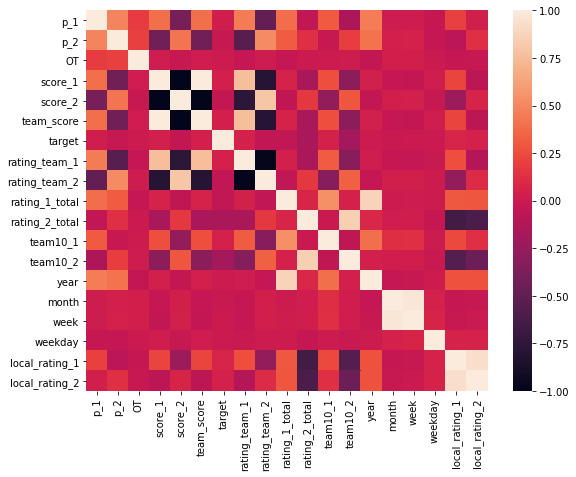

In [83]:
corr = df_Boston_Celtics_total.corr()
f, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(corr, 
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)

In [84]:
def fn_train_test(df):
    Y = df['team_2'].copy()
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    df['team_2_encod'] = encoded_Y
    data = df[['team_2_encod',# 'date',
               'p_1',
               'p_2',
               'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]]#[:-1]
   

    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(df[['team_2_encod']]).toarray(), index=df.index )
    data = pd.concat([data, enc_df],axis=1)#, ignore_index=True)
    data = data.drop(['team_2_encod'], axis=1)  
    data = data[:-1]
    
    train = data.loc[df['year'] <= 2017]
#     train = data.loc[df_Boston_Celtics_total['year'] <= 2017]
    test = data.loc[df['year'] > 2017]
#     test = data.loc[df_Boston_Celtics_total['year'] > 2017]
    y_train = train['target']
    X_train = train.drop(['target'], axis=1)
    y_test = test['target']
    X_test = test.drop(['target'], axis=1)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test

In [85]:
# XGBClassifier 

In [86]:
X_train, y_train, X_test, y_test = fn_train_test(df_Boston_Celtics_total)

In [87]:
pd.DataFrame(X_test)#.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0.699621,0.546219,-0.249777,0.894765,-0.894765,0.029385,-0.156260,2.495493,2.547675,2.378746,-1.580695,0.722021,-1.123033,-1.281358,-1.358267,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
1,0.180027,-0.859851,-0.249777,0.894765,-0.894765,1.015615,-1.030208,0.443509,0.021426,2.433293,-0.252811,1.260683,-0.172761,-0.564054,-0.697159,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
2,-0.772561,-1.190690,-0.249777,0.894765,-0.894765,0.443176,-0.548584,0.458328,0.263186,2.461866,-1.030514,1.243239,-0.121679,-0.085852,-0.201327,...,-0.155097,-0.226156,-0.217834,6.696727,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
3,-1.118957,-1.107980,-0.249777,0.894765,-0.894765,-0.008714,-0.118028,2.533257,2.603174,2.469933,-1.579145,1.273597,-0.663240,0.153249,0.019042,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
4,1.219214,0.380799,-0.249777,0.894765,-0.894765,0.620466,-0.704795,2.319716,2.121025,2.506550,-1.756823,1.511568,-0.793771,1.109654,1.010704,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,4.421733,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.339567,0.959769,-0.249777,-1.117612,1.117612,-1.148204,1.229664,2.919252,3.535007,4.127562,-1.680377,-0.009735,-0.909603,-0.803155,-0.697159,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
120,0.872818,0.546219,-0.249777,0.894765,-0.894765,0.173312,-0.297373,0.292490,0.203052,4.143889,2.186700,0.430838,1.421687,-1.042257,-1.082805,...,-0.155097,4.421733,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
121,1.046016,0.298089,-0.249777,0.894765,-0.894765,0.554297,-0.647274,0.449838,0.209354,4.177503,2.179379,0.533323,1.459762,-0.564054,-0.642066,...,-0.155097,4.421733,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834
122,1.479011,-0.115461,-0.249777,0.894765,-0.894765,1.371471,-1.299115,0.767803,0.223187,4.248198,1.606978,0.806951,1.040382,-0.085852,-0.146235,...,-0.155097,-0.226156,-0.217834,-0.149327,-0.230225,-0.160678,-0.213574,-0.226156,-0.155097,-0.149327,-0.155097,-0.160678,-0.226156,-0.155097,-0.217834


In [88]:
def fn_metric(clf):
    print(y_test.array, '= y_test')
    print(clf.predict(X_test))
    print(clf.score(X_test, y_test))
# print(accuracy_score(clf.predict(X_test), y_test))
    print(confusion_matrix(clf.predict(X_test), y_test))  
    print(classification_report(clf.predict(X_test), y_test)) 
    print(confusion_matrix(clf.predict(X_train), y_train))  
    print(classification_report(clf.predict(X_train), y_train)) 

In [89]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [90]:
clf = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [91]:
clf.fit(X_train, y_train)
# clf = XGBClassifier(random_state=0).fit(X_train, y_train)
fn_metric(clf)

<PandasArray>
[1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
 ...
 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Length: 124, dtype: int64 = y_test
[1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0
 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1]
0.43548387096774194
[[12 16]
 [54 42]]
              precision    recall  f1-score   support

           0       0.18      0.43      0.26        28
           1       0.72      0.44      0.55        96

    accuracy                           0.44       124
   macro avg       0.45      0.43      0.40       124
weighted avg       0.60      0.44      0.48       124

[[263   2]
 [  7 324]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       265
           1       0.99      0.98      0.99       331

    accuracy                           0.98       596
   macro avg       0.98 

In [92]:
# clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

clf = SVC(random_state=0).fit(X_train, y_train)
# clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)


# svm.SVC() 

In [93]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
fn_metric(clf)

<PandasArray>
[1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
 ...
 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Length: 124, dtype: int64 = y_test
[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1
 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 0 0 0 0 1 0 0 0 1]
0.49193548387096775
[[22 19]
 [44 39]]
              precision    recall  f1-score   support

           0       0.33      0.54      0.41        41
           1       0.67      0.47      0.55        83

    accuracy                           0.49       124
   macro avg       0.50      0.50      0.48       124
weighted avg       0.56      0.49      0.51       124

[[144  74]
 [126 252]]
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       218
           1       0.77      0.67      0.72       378

    accuracy                           0.66       596
   macro avg       0.65 

In [94]:
clf = SVC(random_state=0).fit(X_train, y_train)
# clf.predict(X_train)

In [95]:
clf = SVC(random_state=0).fit(X_train, y_train)
fn_metric(clf)

<PandasArray>
[1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
 ...
 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Length: 124, dtype: int64 = y_test
[1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0
 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1]
0.5080645161290323
[[14  9]
 [52 49]]
              precision    recall  f1-score   support

           0       0.21      0.61      0.31        23
           1       0.84      0.49      0.62       101

    accuracy                           0.51       124
   macro avg       0.53      0.55      0.47       124
weighted avg       0.73      0.51      0.56       124

[[138  39]
 [132 287]]
              precision    recall  f1-score   support

           0       0.51      0.78      0.62       177
           1       0.88      0.68      0.77       419

    accuracy                           0.71       596
   macro avg       0.70  

In [96]:
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
fn_metric(clf)

<PandasArray>
[1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
 ...
 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Length: 124, dtype: int64 = y_test
[1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1
 1 0 1 1 0 0 0 0 1 0 0 0 1]
0.5080645161290323
[[27 22]
 [39 36]]
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        49
           1       0.62      0.48      0.54        75

    accuracy                           0.51       124
   macro avg       0.51      0.52      0.51       124
weighted avg       0.54      0.51      0.51       124

[[270   0]
 [  0 326]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       270
           1       1.00      1.00      1.00       326

    accuracy                           1.00       596
   macro avg       1.00  

### перепробовано намного больше вариантов  - результаты не более 0.6

## Обучение на конвеере из различных классификаторов.
## conveyor

In [97]:
from sklearn.tree import ExtraTreeClassifier
clf_arr = [LogisticRegression, #xgb.XGBRegressor()
           LogisticRegressionCV, 
           SVC, 
           DecisionTreeClassifier,
          ExtraTreeClassifier,
          XGBClassifier
]
# конвеер классификаторов 
def fn_conveyor_clf(data, clf_arr=SVC, random_state=0):#, fn_train_test=fn_train_test):
    team_one = data['team_2'].unique()    
    lz = []
    for i in clf_arr:
        z = []
        for j in team_one:
            data_team_one = data.loc[data.values == j]
            X_train, y_train, X_test, y_test = fn_train_test(data_team_one)            
            clf = i(random_state=random_state).fit(X_train, y_train)
            z.append(clf.score(X_test, y_test))
        print(clf)
        print(np.mean(z))
        lz.append(z)

   
    return lz, np.mean(lz)

In [98]:
fn_conveyor_clf(df_Boston_Celtics_total_loc, clf_arr, 0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.5836309523809523
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=0, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)
0.5318452380952381
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
0.562797619047619
DecisionTreeClassifie

([[0.6666666666666666,
   0.4,
   0.6,
   1.0,
   0.6666666666666666,
   0.75,
   0.5,
   0.0,
   1.0,
   0.6,
   0.6666666666666666,
   0.0,
   0.6666666666666666,
   0.6666666666666666,
   0.0,
   0.8,
   0.875,
   0.4,
   0.25,
   1.0,
   1.0,
   0.5,
   1.0,
   0.0,
   0.5,
   1.0,
   0.5,
   0.3333333333333333],
  [1.0,
   0.4,
   0.2,
   0.5,
   0.3333333333333333,
   0.25,
   0.5,
   0.0,
   1.0,
   0.6,
   0.5,
   0.2,
   0.6666666666666666,
   0.3333333333333333,
   0.0,
   0.6,
   0.625,
   0.6,
   0.25,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.5,
   1.0,
   0.5,
   0.3333333333333333],
  [0.6666666666666666,
   0.4,
   0.8,
   1.0,
   0.3333333333333333,
   0.25,
   0.0,
   0.0,
   1.0,
   0.6,
   0.6666666666666666,
   0.8,
   0.6666666666666666,
   0.3333333333333333,
   0.0,
   0.6,
   0.625,
   0.6,
   0.25,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.5,
   0.5,
   0.5,
   0.6666666666666666],
  [0.6666666666666666,
   0.4,
   0.2,
   0.5,
   0.6666666666666666,
   

# Нейронные сети в различных комбинациях

In [99]:
# функция получения train test valid

def fn_train_test_valid(df):
    Y = df['team_2'].copy()
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    df['team_2_encod'] = encoded_Y
    data = df[['team_2_encod',# 'date',
               'p_1',
               'p_2',
               'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]]#[:-1]
   

    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(df[['team_2_encod']]).toarray(), index=df.index )
    data = pd.concat([data, enc_df],axis=1)#, ignore_index=True)
    data = data.drop(['team_2_encod'], axis=1)  
    data = data[:-1]
    
    
    valid = data.loc[df_Boston_Celtics_total['year'] <= 2011]
    train = data[len(valid):].loc[df_Boston_Celtics_total['year'] <= 2017] 
    test = data.loc[df_Boston_Celtics_total['year'] > 2017]
    y_train = train['target']
    X_train = train.drop(['target'], axis=1)
    y_valid = valid['target']
    X_valid = valid.drop(['target'], axis=1)
    y_test = test['target']
    X_test = test.drop(['target'], axis=1)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test    

In [100]:
X_train, y_train, X_valid, y_valid, X_test, y_test = fn_train_test_valid(df_Boston_Celtics_total_loc)

In [101]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])
# history = model.fit(X_train, y_train, epochs=300, validation_data=(X_valid, y_valid))


In [102]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 510 samples, validate on 86 samples
Epoch 1/30
510/510 [==============================] - 1s 2ms/sample - loss: 0.4372 - accuracy: 0.4608 - val_loss: 0.4470 - val_accuracy: 0.4535
Epoch 2/30
510/510 [==============================] - 0s 108us/sample - loss: 0.4070 - accuracy: 0.4588 - val_loss: 0.4153 - val_accuracy: 0.4535
Epoch 3/30
510/510 [==============================] - 0s 205us/sample - loss: 0.3838 - accuracy: 0.4627 - val_loss: 0.3909 - val_accuracy: 0.4651
Epoch 4/30
510/510 [==============================] - 0s 119us/sample - loss: 0.3660 - accuracy: 0.4667 - val_loss: 0.3723 - val_accuracy: 0.4884
Epoch 5/30
510/510 [==============================] - 0s 123us/sample - loss: 0.3525 - accuracy: 0.4824 - val_loss: 0.3578 - val_accuracy: 0.5000
Epoch 6/30
510/510 [==============================] - 0s 104us/sample - loss: 0.3422 - accuracy: 0.4902 - val_loss: 0.3466 - val_accuracy: 0.4767
Epoch 7/30
510/510 [==============================] - 0s 127us/sample - loss: 0.3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


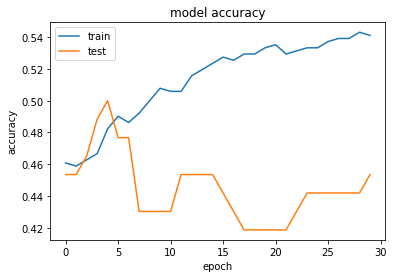

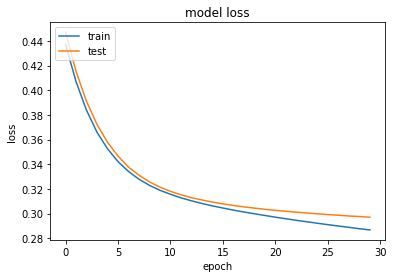

In [103]:
plot_history(history)

In [104]:
mse_test = model.evaluate(X_test, y_test)
mse_test

124/124 [==============================] - 0s 105us/sample - loss: 0.3177 - accuracy: 0.4919


[0.317652863840903, 0.4919355]

In [105]:
predicted_cl = model.predict_classes(X_test)
accuracy_score( y_test, predicted_cl, )

0.49193548387096775

In [106]:
confusion_matrix(predicted_cl, y_test)

array([[19, 16],
       [47, 42]], dtype=int64)

In [107]:
print(classification_report(predicted_cl, y_test))

              precision    recall  f1-score   support

           0       0.29      0.54      0.38        35
           1       0.72      0.47      0.57        89

    accuracy                           0.49       124
   macro avg       0.51      0.51      0.47       124
weighted avg       0.60      0.49      0.52       124



Другой вариант, посложнее:

In [108]:
DROPOUT = 0.2
# model.add(Dropout(DROPOUT))
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])
#               optimizer="sgd",
#               metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=120,
                    validation_data=(X_valid, y_valid))

Train on 510 samples, validate on 86 samples
Epoch 1/120
510/510 [==============================] - 0s 956us/sample - loss: 0.3718 - accuracy: 0.4843 - val_loss: 0.2967 - val_accuracy: 0.6047
Epoch 2/120
510/510 [==============================] - 0s 115us/sample - loss: 0.3677 - accuracy: 0.4804 - val_loss: 0.2946 - val_accuracy: 0.5930
Epoch 3/120
510/510 [==============================] - 0s 119us/sample - loss: 0.3667 - accuracy: 0.4843 - val_loss: 0.2919 - val_accuracy: 0.5698
Epoch 4/120
510/510 [==============================] - 0s 117us/sample - loss: 0.3521 - accuracy: 0.5098 - val_loss: 0.2902 - val_accuracy: 0.5698
Epoch 5/120
510/510 [==============================] - 0s 114us/sample - loss: 0.3365 - accuracy: 0.4824 - val_loss: 0.2888 - val_accuracy: 0.5465
Epoch 6/120
510/510 [==============================] - 0s 123us/sample - loss: 0.3344 - accuracy: 0.5118 - val_loss: 0.2875 - val_accuracy: 0.5581
Epoch 7/120
510/510 [==============================] - 0s 119us/sample - 

510/510 [==============================] - 0s 125us/sample - loss: 0.2749 - accuracy: 0.5176 - val_loss: 0.2632 - val_accuracy: 0.5116
Epoch 57/120
510/510 [==============================] - 0s 115us/sample - loss: 0.2785 - accuracy: 0.5333 - val_loss: 0.2628 - val_accuracy: 0.5116
Epoch 58/120
510/510 [==============================] - 0s 119us/sample - loss: 0.2843 - accuracy: 0.5176 - val_loss: 0.2629 - val_accuracy: 0.5233
Epoch 59/120
510/510 [==============================] - 0s 117us/sample - loss: 0.2893 - accuracy: 0.4647 - val_loss: 0.2629 - val_accuracy: 0.5116
Epoch 60/120
510/510 [==============================] - 0s 121us/sample - loss: 0.2701 - accuracy: 0.5392 - val_loss: 0.2624 - val_accuracy: 0.5116
Epoch 61/120
510/510 [==============================] - 0s 107us/sample - loss: 0.2778 - accuracy: 0.5275 - val_loss: 0.2620 - val_accuracy: 0.5000
Epoch 62/120
510/510 [==============================] - 0s 205us/sample - loss: 0.2791 - accuracy: 0.5157 - val_loss: 0.2617 

510/510 [==============================] - 0s 104us/sample - loss: 0.2616 - accuracy: 0.5235 - val_loss: 0.2504 - val_accuracy: 0.5000
Epoch 112/120
510/510 [==============================] - 0s 108us/sample - loss: 0.2674 - accuracy: 0.5235 - val_loss: 0.2503 - val_accuracy: 0.5000
Epoch 113/120
510/510 [==============================] - 0s 106us/sample - loss: 0.2731 - accuracy: 0.5353 - val_loss: 0.2503 - val_accuracy: 0.5116
Epoch 114/120
510/510 [==============================] - 0s 106us/sample - loss: 0.2538 - accuracy: 0.5510 - val_loss: 0.2503 - val_accuracy: 0.5000
Epoch 115/120
510/510 [==============================] - 0s 102us/sample - loss: 0.2573 - accuracy: 0.5451 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 116/120
510/510 [==============================] - 0s 108us/sample - loss: 0.2538 - accuracy: 0.5373 - val_loss: 0.2498 - val_accuracy: 0.5116
Epoch 117/120
510/510 [==============================] - 0s 137us/sample - loss: 0.2580 - accuracy: 0.5569 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


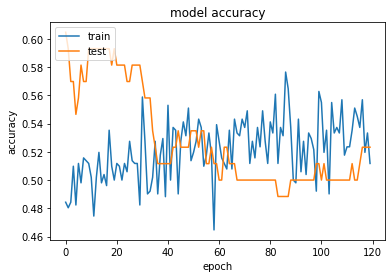

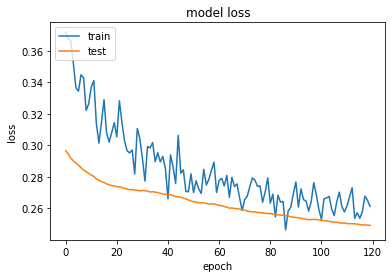

In [109]:
plot_history(history)

In [110]:
mse_test

[0.317652863840903, 0.4919355]

In [111]:
predicted_cl = model.predict_classes(X_test)

In [112]:
acc = accuracy_score(y_test, predicted_cl)
acc

0.5161290322580645

In [113]:
confusion_matrix(predicted_cl, y_test)

array([[33, 27],
       [33, 31]], dtype=int64)

In [114]:
print(classification_report(predicted_cl, y_test))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52        60
           1       0.53      0.48      0.51        64

    accuracy                           0.52       124
   macro avg       0.52      0.52      0.52       124
weighted avg       0.52      0.52      0.52       124



### Предсказание по отдельно взятой команде и сумирование предсказаний

In [115]:
# конвеер предсказаний для отдельных команд
def fn_conveyor_NN_1(data):#, fn_train_test=fn_train_test):
    team_one = data['team_2'].unique()
    z = []
    for j in team_one:
        data_team_one = data.loc[data.values == j]
        X_train, y_train, X_valid, y_valid, X_test, y_test = fn_train_test_valid(data_team_one)
        
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(42, activation="relu", input_shape=X_train.shape[1:]),
            tf.keras.layers.Dense(20, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), verbose=0)
        predicted_cl = model.predict_classes(X_test)

        acc = accuracy_score(y_test, predicted_cl)

        z.append(acc)
    
    print(z)
    print(np.mean(z))
    return np.mean(z)

In [116]:
fn_conveyor_NN_1(df_Boston_Celtics_total_loc)

[1.0, 0.4, 0.6, 0.75, 0.6666666666666666, 0.25, 0.0, 1.0, 1.0, 0.4, 0.5, 0.6, 0.3333333333333333, 0.3333333333333333, 1.0, 0.4, 0.5, 0.8, 0.25, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5, 0.5, 1.0]
0.6351190476190476


0.6351190476190476

### другой вариант

In [117]:
# конвеер предсказаний для отдельных команд
def fn_conveyor_NN_2(data):
    team_one = data['team_2'].unique()
    z = []
    for j in team_one:
        data_team_one = data.loc[data.values == j]
        X_train, y_train, X_valid, y_valid, X_test, y_test = fn_train_test_valid(data_team_one)

        DROPOUT = 0.1
        # model.add(Dropout(DROPOUT))
        model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(40, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dense(1, activation="softmax")
        ])
        model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
#               optimizer="sgd",optimizer=Adam(lr=0.01)
#               metrics=["accuracy"])
        history = model.fit(X_train, y_train, epochs=120,
                            validation_data=(X_valid, y_valid), verbose=0)             
        predicted_cl = model.predict_classes(X_test)
        acc = accuracy_score(y_test, predicted_cl)
        z.append(acc)
    print(z)
    print('mean_accuracy= ', np.mean(z))

    return np.mean(z)

In [118]:
fn_conveyor_NN_2(df_Boston_Celtics_total_loc)

[1.0, 0.8, 0.8, 0.75, 0.3333333333333333, 0.75, 1.0, 1.0, 1.0, 0.6, 0.5, 0.8, 0.6666666666666666, 0.3333333333333333, 0.0, 0.6, 0.625, 0.6, 0.25, 1.0, 0.0, 0.0, 1.0, 0.0, 0.5, 0.5, 0.5, 0.0]
mean_accuracy=  0.5681547619047619


0.5681547619047619

In [119]:

gc.collect()

73401

### Обучение скользящим окном
### Window

In [120]:
df_Boston_Celtics_total_loc.to_csv('df_Boston_Celtics_total_loc', index=False)
df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc')
df_Boston_loc.loc[df_Boston_loc['team_2'] == 'Miami Heat'].head()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2,team_2_encod
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,1,1,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2,0.200000,-0.181818,14
8,2010-12-11 04:00:00,Boston Celtics,Miami Heat,112,107,1,1,0,1,1,0.093458,-0.089286,1.026598,2.132477,1.026598,2.132477,2010,12,49,5,0.293458,0.110714,14
52,2011-02-13 21:00:00,Boston Celtics,Miami Heat,85,82,1,1,0,1,0,0.073171,-0.070588,8.367980,10.062669,1.028328,2.135911,2011,2,6,6,0.366629,0.222870,14
79,2011-10-04 23:30:00,Boston Celtics,Miami Heat,77,100,1,0,1,0,0,-0.460000,0.597403,10.759979,13.926528,0.746528,2.507653,2011,10,40,1,-0.093371,0.964031,14
83,2011-12-28 05:00:00,Boston Celtics,Miami Heat,107,115,1,0,1,0,1,-0.139130,0.149533,10.763402,14.943577,0.654644,3.300854,2011,12,52,2,-0.232502,0.056161,14


In [121]:
data_t = df_Boston_loc.loc[df_Boston_loc.values == 'Miami Heat']
data_t[:]

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2,team_2_encod
0,2010-10-27 03:30:00,Boston Celtics,Miami Heat,88,80,1,1,0,1,1,0.200000,-0.181818,0.200000,-0.181818,0.200000,-0.181818,2010,10,43,2,0.200000,-0.181818,14
8,2010-12-11 04:00:00,Boston Celtics,Miami Heat,112,107,1,1,0,1,1,0.093458,-0.089286,1.026598,2.132477,1.026598,2.132477,2010,12,49,5,0.293458,0.110714,14
52,2011-02-13 21:00:00,Boston Celtics,Miami Heat,85,82,1,1,0,1,0,0.073171,-0.070588,8.367980,10.062669,1.028328,2.135911,2011,2,6,6,0.366629,0.222870,14
79,2011-10-04 23:30:00,Boston Celtics,Miami Heat,77,100,1,0,1,0,0,-0.460000,0.597403,10.759979,13.926528,0.746528,2.507653,2011,10,40,1,-0.093371,0.964031,14
83,2011-12-28 05:00:00,Boston Celtics,Miami Heat,107,115,1,0,1,0,1,-0.139130,0.149533,10.763402,14.943577,0.654644,3.300854,2011,12,52,2,-0.232502,0.056161,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,2017-12-21 03:30:00,Boston Celtics,Miami Heat,89,90,1,0,1,0,0,-0.022222,0.022472,28.936622,52.091554,1.642664,2.923045,2017,12,51,3,1.162497,1.207192,14
679,2019-11-01 03:00:00,Boston Celtics,Miami Heat,99,115,1,0,1,0,1,-0.278261,0.323232,38.006812,56.220494,3.398898,4.186914,2019,11,44,4,0.884237,1.485730,14
685,2019-01-22 02:00:00,Boston Celtics,Miami Heat,107,99,1,1,0,1,1,0.161616,-0.149533,38.424388,55.701936,3.377601,2.716454,2019,1,4,1,1.045853,0.734704,14
716,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,1,1,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0,1.141091,0.954944,14


In [122]:
data_t[-1:]#['target']

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2,team_2_encod
717,2019-04-04 02:30:00,Boston Celtics,Miami Heat,112,102,1,1,0,1,0,0.196078,-0.178571,39.971187,56.19032,1.76969,3.061785,2019,4,14,3,1.337169,0.962519,14


In [123]:
def fn_clf_win_train_test(df):
    data = df[[# 'date',
               'p_1',
               'p_2',
#                'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]]#[:-1]
    
    train = data[:-1]
    test = data[-1:]
    y_train = train['target']
    X_train = train.drop(['target'], axis=1)
    y_test = test['target']#.values[0]
    X_test = test.drop(['target'], axis=1)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test

### Функция обучения скользящим окном по двум командам, (window=10) предсказывается результат в следующем окне

In [124]:
clf_arr = [LogisticRegression, #xgb.XGBRegressor()
           LogisticRegressionCV, 
           SVC, 
           DecisionTreeClassifier,
          ExtraTreeClassifier,
          XGBClassifier
]

# Функция обучения скользящим окном по двум командам, (window=10) предсказывается результат в следующем окне

def fn_clf_window(data, clf_arr=[SVC, XGBClassifier], window=10, random_state=0):
    team_one = data['team_2'].unique() 
    lz = []
    for i in clf_arr:
        z = []
        print(i)
        for j in team_one:
            pred_cl = []
            y_test = []
            data_team_one = data.loc[data.values == j]
            n_wind = data_team_one.shape[0] - window
#             print(j)
            for k in range(n_wind):
                data_window = data_team_one[k :(k + window)]
                X_train, y_train, X_test_k, y_test_k = fn_clf_win_train_test(data_window)
                if len(y_train) == 0:
                    print('continue_len_0')
                    continue
                if y_train.sum() == len(y_train):
                    print('continue.sum_1')
                    continue
                if y_train.sum() == 0:
                    print('continue.sum_0')

                clf = i(random_state=random_state).fit(X_train, y_train)
                pred_k = clf.predict(X_test_k)[0]
                pred_cl.append(pred_k)
                y_test.append(y_test_k.values[0])

            acc = accuracy_score(y_test, pred_cl)
            z.append(acc)
        
            print('pred_cl', pred_cl)
            print('y_test ', y_test)
            print('accuracy_score = ', acc)

        print('z', z)
        print()
        print('np.mean(z)', np.mean(z))
        cleaned = [z for z in z if not math.isnan(z)]
        print('np.mean(cleaned) = ', np.mean(cleaned))
        z = cleaned
        print()
        print()
        lz.append(z)
   
    return np.mean(lz)

In [125]:
# # def fn_data_trans(data, ins=10, mem=0)
# data_trans = fn_data_trans(data, 10, 0.0)
# df_Boston_Celtics = data_trans.loc[data_trans.values == 'Boston Celtics']
# df_Boston_Celtics_total = fn_rename_total(df_Boston_Celtics, 'Boston Celtics')
# df_Boston_Celtics_total_loc = fn_target_one_total_local_rating(df_Boston_Celtics_total)
# df_Boston_Celtics_total_loc.to_csv('df_Boston_Celtics_total_loc', index=False)
# # df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc')
# df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc')
# df_Boston_loc.tail()

In [126]:
df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc')
df_Boston_loc.tail()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2,team_2_encod
716,2019-02-04 02:30:00,Boston Celtics,Miami Heat,110,105,1,1,0,1,1,0.095238,-0.090909,39.775109,56.368892,1.668611,2.988144,2019,2,6,0,1.141091,0.954944,14
717,2019-04-04 02:30:00,Boston Celtics,Miami Heat,112,102,1,1,0,1,0,0.196078,-0.178571,39.971187,56.190320,1.769690,3.061785,2019,4,14,3,1.337169,0.962519,14
718,2019-06-04 03:00:00,Boston Celtics,Indiana Pacers,117,97,1,1,0,1,0,0.412371,-0.341880,40.383558,42.230181,2.039561,2.250653,2019,6,23,1,1.733401,0.979150,10
719,2019-08-04 02:30:00,Boston Celtics,Orlando Magic,108,116,1,0,1,0,0,-0.137931,0.148148,40.245627,-27.024123,2.051630,0.279652,2019,8,31,6,5.421197,5.707276,19
720,2019-10-04 02:00:00,Boston Celtics,Washington Wizards,116,110,1,1,0,1,0,0.109091,-0.103448,40.354718,-7.849760,2.209026,-1.158776,2019,10,40,4,2.942406,2.729867,27


In [127]:
df_Boston_loc.loc[df_Boston_loc.values =='Indiana Pacers'].tail()

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2,team_2_encod
623,2018-12-03 02:30:00,Boston Celtics,Indiana Pacers,97,99,1,0,1,0,0,-0.040404,0.041237,31.635608,34.835392,2.585820,2.592877,2018,12,49,0,0.804924,0.886565,10
647,2018-04-11 02:00:00,Boston Celtics,Indiana Pacers,101,102,1,0,1,0,1,-0.019608,0.019802,32.794879,36.140522,2.711931,2.917753,2018,4,15,2,0.785316,0.824726,10
678,2019-10-01 03:00:00,Boston Celtics,Indiana Pacers,135,108,1,1,0,1,1,0.500000,-0.400000,38.285072,39.849215,3.471326,3.022866,2019,10,40,1,1.285316,0.385316,10
714,2019-03-30 02:00:00,Boston Celtics,Indiana Pacers,114,112,1,1,0,1,1,0.035714,-0.035088,39.934416,42.051269,1.719474,1.862558,2019,3,13,5,1.321030,1.250228,10
718,2019-06-04 03:00:00,Boston Celtics,Indiana Pacers,117,97,1,1,0,1,0,0.412371,-0.341880,40.383558,42.230181,2.039561,2.250653,2019,6,23,1,1.733401,0.979150,10


In [128]:
result = fn_clf_window(df_Boston_loc, clf_arr, 15, 0)
result

<class 'sklearn.linear_model._logistic.LogisticRegression'>
pred_cl [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
y_test  [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
accuracy_score =  0.5555555555555556
pred_cl [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1]
y_test  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
accuracy_score =  0.75
pred_cl [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
y_test  [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
accuracy_score =  0.6666666666666666
pred_cl [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
y_test  [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
accuracy_score =  0.7647058823529411
pred_cl [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
y_test  [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]
accuracy_score =  0.5
pred_cl [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
y_test  [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
accuracy_score =  0.5555555555555556
pre

pred_cl [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
y_test  [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
accuracy_score =  0.47619047619047616
pred_cl [1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1]
y_test  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
accuracy_score =  0.35294117647058826
pred_cl [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_test  [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
accuracy_score =  0.55
pred_cl [1, 1]
y_test  [0, 0]
accuracy_score =  0.0
pred_cl [1, 1]
y_test  [0, 0]
accuracy_score =  0.0
pred_cl [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
accuracy_score =  0.75
pred_cl [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_test  [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
accuracy_sco

pred_cl [1, 1]
y_test  [1, 1]
accuracy_score =  1.0
pred_cl [1, 0]
y_test  [0, 0]
accuracy_score =  0.5
pred_cl [1, 1]
y_test  [1, 0]
accuracy_score =  0.5
pred_cl [1, 0, 0]
y_test  [0, 0, 1]
accuracy_score =  0.3333333333333333
pred_cl [0, 0]
y_test  [0, 1]
accuracy_score =  0.5
pred_cl [0, 0]
y_test  [0, 0]
accuracy_score =  1.0
z [0.5, 0.75, 0.5238095238095238, 0.5294117647058824, 0.375, 0.3888888888888889, 0.3333333333333333, 0.0, 0.5, 0.5, 0.6666666666666666, 0.35294117647058826, 0.65, 0.5, 1.0, 0.65, 0.6176470588235294, 0.8333333333333334, 0.625, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 0.3333333333333333, 0.5, 1.0]

np.mean(z) 0.59390589569161
np.mean(cleaned) =  0.59390589569161


<class 'xgboost.sklearn.XGBClassifier'>
pred_cl [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]
y_test  [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
accuracy_score =  0.4444444444444444
pred_cl [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,

0.5602444450002223

### latest games - предсказание последних N игр. Targert = +1 игра

In [129]:
def fn_clf_latest_games_train_test(df):
    data = df[[# 'date',
               'p_1',
               'p_2',
               'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]]#[:-1]
    
    train = data[:-1]
    test = data[-1:]
    y_train = train['target']
    X_train = train.drop(['target'], axis=1)
    y_test = test['target']#.values[0]
    X_test = test.drop(['target'], axis=1)
#     sc = MinMaxScaler()
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test

In [130]:
# предсказание последних (latest_games=5) игр. Targert - +1 игра
# latest games - обучение на всех играх, до (latest_games=5) предсказание следующей игры (latest_games -1) .

clf_arr = [LogisticRegression, 
           LogisticRegressionCV, 
           SVC, 
           DecisionTreeClassifier,
          ExtraTreeClassifier,
          XGBClassifier
]

def fn_clf_latest_games(data, clf_arr=[SVC, DecisionTreeClassifier], latest_games=5, random_state=0):
    team_one = data['team_2'].unique() 
    lz = []
    for i in clf_arr:
        z = []
        print(i)
        for j in team_one:
            pred_cl = []
            y_test = []
            data_team_one = data.loc[data.values == j]
#             n_wind = data_team_one.shape[0] - window
            n_wind = data_team_one.shape[0] #- window
            print(j)
#             for k in range(n_wind):
            for k in range(latest_games):
                data_window = data_team_one[:(n_wind + k - latest_games)]
                X_train, y_train, X_test_k, y_test_k = fn_clf_latest_games_train_test(data_window)
                if len(y_train) == 0:
                    print('continue_len_0')
                    continue
                if y_train.sum() == len(y_train):
                    print('continue.sum_1')
                    continue
                if y_train.sum() == 0:
                    print('continue.sum_0')
                    continue
                clf = i(random_state=random_state).fit(X_train, y_train)
                pred_k = clf.predict(X_test_k)[0]
                pred_cl.append(pred_k)
                y_test.append(y_test_k.values[0])
                
#                 print('X_test', X_test_k)
#                 print('y_test ', y_test_k)
#                 print('pred_k = ', pred_k, y_test_k.values[0], '= y')
#                 y_test.append(y_test_k)
#                 y_test.append(y_test_k.values[0])
#                 z.append(clf.score(X_test, y_test))
            acc = accuracy_score(y_test, pred_cl)
            z.append(acc)
        
            print('pred_cl', pred_cl)
            print('y_test ', y_test)
            print('accuracy_score =', acc)
#             print()
        
        print('z', z)
        print()
        print('np.mean(z)', np.mean(z))
#         if np.mean(z) is NaN:
        cleaned = [z for z in z if not math.isnan(z)]
#         print ([z for z in z if not math.isnan(z)])
        print('np.mean(cleaned) = ', np.mean(cleaned))
        z = cleaned
            
#         cleaned = [z for z in z if z != 'nan'] 
#         cleaned = z[numpy.logical_not(numpy.isnan(z))]
#         print('cleaned = ', cleaned)
#         print('np.mean(cleaned) = ', np.mean(cleaned))
        
            
        print()
        print()
        lz.append(z)
   
    return np.mean(lz)

In [131]:
gc.collect()

20

In [132]:
# def fn_data_trans(data, ins=10, mem=0)
data_common = pd.read_csv('data_common.csv')
data_trans = fn_data_trans(data_common, 12, 0.0)
df_Indiana_Pacers = data_trans.loc[data_trans.values == 'Indiana Pacers']
df_Indiana_Pacers_total = fn_rename_total(df_Indiana_Pacers, 'Indiana Pacers')
df_Indiana_Pacers_total_loc = fn_target_one_total_local_rating(df_Indiana_Pacers_total)
df_Indiana_Pacers_total_loc.to_csv('df_Indiana_Pacers_total_loc', index=False)
# df_Indiana_loc = pd.read_csv('df_Indiana_Pacers_total_loc')

In [133]:
df_Indiana_loc = pd.read_csv('df_Indiana_Pacers_total_loc')

In [134]:
df_Indiana_loc.loc[df_Indiana_loc.values == 'Miami Heat']

,date,team_1,team_2,p_1,p_2,ОТ,score_1,score_2,team_score,target,rating_team_1,rating_team_2,rating_1_total,rating_2_total,team10_1,team10_2,year,month,week,weekday,local_rating_1,local_rating_2
11,2010-11-23 03:30:00,Indiana Pacers,Miami Heat,93,77,1,1,0,1,0,0.415584,-0.344086,1.173537,2.673561,1.173537,2.625495,2010,11,47,1,0.415584,-0.344086
48,2011-09-02 03:30:00,Indiana Pacers,Miami Heat,112,117,1,0,1,0,0,-0.085470,0.089286,0.346682,9.828909,0.530981,1.259159,2011,9,35,4,0.330114,0.504870
52,2011-02-16 03:00:00,Indiana Pacers,Miami Heat,103,110,1,0,1,0,0,-0.127273,0.135922,0.572062,10.198591,1.250029,2.184733,2011,2,7,2,0.202842,0.466037
87,2012-05-01 04:30:00,Indiana Pacers,Miami Heat,83,118,1,0,1,0,0,-0.593220,0.843373,-0.710362,16.554274,0.129699,3.288795,2012,5,18,1,-0.390379,1.046215
109,2012-02-15 04:00:00,Indiana Pacers,Miami Heat,90,105,1,0,1,0,0,-0.285714,0.333333,0.760702,20.438154,0.374348,2.741129,2012,2,7,2,-0.676093,-0.057045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,2018-11-01 03:00:00,Indiana Pacers,Miami Heat,106,114,1,0,1,0,1,-0.140351,0.150943,32.802926,52.520010,0.134040,0.341836,2018,11,44,3,0.804866,1.096160
630,2018-03-26 00:00:00,Indiana Pacers,Miami Heat,113,107,2,1,0,1,1,0.084112,-0.079646,34.933033,54.124875,0.459549,1.289315,2018,3,13,0,0.888978,0.725220
651,2018-10-11 04:00:00,Indiana Pacers,Miami Heat,110,102,1,1,0,1,1,0.156863,-0.145455,36.095752,55.163618,0.449718,0.372645,2018,10,41,3,1.045841,0.743524
653,2018-11-17 03:00:00,Indiana Pacers,Miami Heat,99,91,1,1,0,1,1,0.175824,-0.161616,36.062880,54.980254,0.347839,0.150485,2018,11,46,5,1.221665,0.884225


In [135]:
fn_clf_latest_games(df_Indiana_loc, clf_arr)


<class 'sklearn.linear_model._logistic.LogisticRegression'>
San Antonio Spurs
pred_cl [0, 0, 0, 0, 1]
y_test  [0, 1, 1, 1, 0]
accuracy_score = 0.2
Charlotte Hornets
pred_cl [1, 0, 0, 0, 1]
y_test  [0, 1, 1, 1, 1]
accuracy_score = 0.2
Philadelphia 76ers
pred_cl [1, 1, 1, 0, 1]
y_test  [1, 0, 1, 0, 0]
accuracy_score = 0.6
Milwaukee Bucks
pred_cl [1, 1, 1, 0, 1]
y_test  [1, 0, 1, 0, 0]
accuracy_score = 0.6
Denver Nuggets
pred_cl [1, 0, 0, 1, 1]
y_test  [0, 1, 0, 0, 1]
accuracy_score = 0.4
Houston Rockets
pred_cl [1, 1, 0, 0, 1]
y_test  [1, 0, 0, 0, 0]
accuracy_score = 0.6
Cleveland Cavaliers
pred_cl [0, 0, 1, 0, 1]
y_test  [0, 1, 0, 1, 1]
accuracy_score = 0.4
Atlanta Hawks
pred_cl [0, 0, 1, 1, 1]
y_test  [1, 1, 1, 1, 1]
accuracy_score = 0.6
Los Angeles Clippers
pred_cl [0, 0, 1, 1, 1]
y_test  [1, 1, 1, 1, 0]
accuracy_score = 0.4
Orlando Magic
pred_cl [1, 1, 1, 1, 0]
y_test  [1, 1, 0, 0, 0]
accuracy_score = 0.6
Miami Heat
pred_cl [0, 0, 0, 1, 1]
y_test  [0, 1, 1, 1, 1]
accuracy_score = 0.6

Milwaukee Bucks
pred_cl [1, 1, 0, 0, 1]
y_test  [1, 0, 1, 0, 0]
accuracy_score = 0.4
Denver Nuggets
pred_cl [0, 0, 0, 0, 1]
y_test  [0, 1, 0, 0, 1]
accuracy_score = 0.8
Houston Rockets
pred_cl [1, 1, 0, 0, 1]
y_test  [1, 0, 0, 0, 0]
accuracy_score = 0.6
Cleveland Cavaliers
pred_cl [1, 0, 1, 1, 1]
y_test  [0, 1, 0, 1, 1]
accuracy_score = 0.4
Atlanta Hawks
pred_cl [0, 0, 0, 1, 1]
y_test  [1, 1, 1, 1, 1]
accuracy_score = 0.4
Los Angeles Clippers
pred_cl [0, 1, 0, 0, 1]
y_test  [1, 1, 1, 1, 0]
accuracy_score = 0.2
Orlando Magic
pred_cl [1, 1, 1, 0, 0]
y_test  [1, 1, 0, 0, 0]
accuracy_score = 0.8
Miami Heat
pred_cl [0, 0, 0, 1, 1]
y_test  [0, 1, 1, 1, 1]
accuracy_score = 0.6
Oklahoma City Thunder
pred_cl [0, 0, 1, 0, 1]
y_test  [1, 0, 0, 1, 0]
accuracy_score = 0.2
Los Angeles Lakers
pred_cl [1, 1, 0, 1, 1]
y_test  [0, 0, 1, 0, 1]
accuracy_score = 0.2
Sacramento Kings
pred_cl [1, 1, 1, 1, 0]
y_test  [1, 1, 1, 0, 1]
accuracy_score = 0.6
Utah Jazz
pred_cl [0, 1, 1, 0, 0]
y_test  [1, 1, 0, 1, 1

0.5083333333333334

In [136]:
gc.collect()

297

### Предсказание последних игр на нейроннных сетях

In [16]:
def fn_NN_latest_games_train_test(df, len_test=1):
    data = df[[# 'date',
               'p_1',
               'p_2',
#                'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]][:-1]
    
    train = data[:-len_test]
    test = data[-len_test:]
    y_train = train['target']
    X_train = train.drop(['target'], axis=1)
    y_test = test['target']#.values[0]
    X_test = test.drop(['target'], axis=1)
#     sc = MinMaxScaler()
    sc = StandardScaler()
#     sc = QuantileTransformer()

    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, y_train, X_test, y_test

In [88]:
# Предсказание с выделением команд, где предсказания выше acc_min=0.7

def fn_NN_2_latest_games(data, latest_games=5, team_one=[], epochs=20, mdls=10, acc_min=0.7, clf_arr=1):
    if team_one == []:
        team_one = data['team_2'].unique() 
    lz = []
    teams_max = []
    teams_min = []
    for i in range(clf_arr):
        z = []
        z_y = []
        print(i)
        for j in team_one:
            pred_cl = []
            pred_it = []
            y_test = []
            data_team_one = data.loc[data.values == j]
#             n_wind = data_team_one.shape[0] - window
            n_wind = data_team_one.shape[0] #- window
            print()
            print('_________________________________________________')
            print(j)
            
            X_train2, _, _, _ = fn_NN_latest_games_train_test(data)
            shar = X_train2.shape[1:]
            shar_0 = X_train2.shape[1]
            print('shar_0', shar_0)
            DROPOUT = 0.2
            BATCH_SIZE = 2
            model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(shar_0, activation="relu", input_shape=shar),
            tf.keras.layers.Dropout(DROPOUT),
            tf.keras.layers.Dense(shar_0, activation="relu"),
            tf.keras.layers.Dropout(DROPOUT),
#             tf.keras.layers.Dense(12, activation="relu"),
#             tf.keras.layers.Dropout(0.2),
                
#             tf.keras.layers.Dense((shar_0*2), activation="relu"),# min3
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense((shar_0*2), activation="relu"),
#             tf.keras.layers.Dropout(0.3),
                
                
            tf.keras.layers.Dense(6, activation="relu"),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1)
            ])                
#             if retraining is False:
#                 model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
            
            mod_max, mod_2 = 0, 0
            for m in range(mdls):
                pred_cl = []
                pred_it = []
                y_test = []
            
                for k in range(latest_games):
                    data_window = data_team_one[:(n_wind + k - latest_games)]
                    X_train, y_train, X_test_k, y_test_k = fn_NN_latest_games_train_test(data_window)
                    if len(y_train) == 0:
                        print('continue_len_0')
                        continue
                    if y_train.sum() == len(y_train):
                        print('continue.sum_1')
                        continue
                    if y_train.sum() == 0:
                        print('continue.sum_0')
                
                    if k == 0:
                        model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
                        best_model = model#.copy()
                        print('model.compile')
                        history = model.fit(X_train, y_train, epochs=40, batch_size=BATCH_SIZE, verbose=0)                                
                    else:
                        history = model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE, verbose=0)
#                         print('k != 0 ', k)

                    pred_k = model.predict_classes(X_test_k)[0][0]
                    pred_cl.append(pred_k)
                    y_test.append(y_test_k.values[0])
                
                acc = accuracy_score(y_test, pred_cl)
                if m == 0:
                    mod_max = acc
                    best_model.save("models_2/model_{}.h5".format(j))#cv2.imwrite("img_train_100//{}.jpg".format(i), img_new)
                    print('save, mod_max = ', mod_max, 'mdls = ', m)
                
                mod_2 = acc
                
#                 if m == 0:
                    
                if mod_2 > mod_max :
#                     best_model = model
                    best_model.save("models_2/model_{}.h5".format(j))#cv2.imwrite("img_train_100//{}.jpg".format(i), img_new)
                    mod_max = mod_2
                    print('save, mod_2 =+++++', mod_2, 'mdls = ', m)
    
                
#                 acc = accuracy_score(y_test, pred_cl)
#                 if m == 0:
#                     mod_1 = acc   
#                 mod_2 = acc
                z.append(mod_max)
#                 if acc > acc_min:
#                     teams_max.append(j)
#                 else:
#                     teams_min.append(j)
                print('mdls ==========', m)    
                print('pred_cl', pred_cl)
                print('y_test ', y_test)
                print('accuracy_score =', acc)
            if mod_max > acc_min:
                teams_max.append(j)
            else:
                teams_min.append(j)
#             print('pred_cl', pred_cl)
#             print('y_test ', y_test)
#             print('accuracy_score =', acc)
        
        print()
        print('np.mean(z)', np.mean(z))
#         if np.mean(z) is NaN:
        cleaned = [z for z in z if not math.isnan(z)]
        print('np.mean(cleaned) = ', np.mean(cleaned))
        z = cleaned
        print()
        print()
        lz.append(z)
    print('teams_max', len(teams_max), 'pred_cl = ', np.sum(z), 'data = ', data.shape[0])
    return teams_max, teams_min, np.mean(lz)

In [67]:
gc.collect()

106128

In [72]:
teams_max, teams_min, np_mean = fn_NN_2_latest_games(df_Indiana_loc, 7, [])

0
San Antonio Spurs
shar_0 16
save, mod_1 =  0.42857142857142855 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
mdls ========== 1
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
mdls ========== 2
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
mdls ========== 3
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
mdls ========== 4
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
save, mod_2 =  0.5714285714285714 mdls =  5
mdls ========== 5
pred_cl [0, 1, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.5714285714285714
mdls ========== 6
pred_cl [0, 1, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.5714285714285714
mdls ========== 7
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]


save, mod_1 =  0.2857142857142857 mdls =  0
mdls ========== 0
pred_cl [0, 1, 0, 0, 0, 1, 0]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.2857142857142857
save, mod_2 =  0.5714285714285714 mdls =  1
mdls ========== 1
pred_cl [1, 1, 0, 0, 0, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.5714285714285714
save, mod_2 =  0.8571428571428571 mdls =  2
mdls ========== 2
pred_cl [1, 1, 1, 0, 1, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.8571428571428571
mdls ========== 3
pred_cl [1, 1, 1, 0, 1, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.8571428571428571
mdls ========== 4
pred_cl [1, 1, 1, 0, 0, 1, 0]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.5714285714285714
mdls ========== 5
pred_cl [1, 1, 1, 0, 1, 1, 0]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.7142857142857143
mdls ========== 6
pred_cl [1, 1, 1, 0, 1, 1, 0]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.7142857142857143
mdls ========== 7
pred_cl [1, 1, 1, 0, 1, 1, 1]
y_test  [1, 1, 1, 0, 1

mdls ========== 1
pred_cl [1, 0, 1, 1, 1, 0, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.42857142857142855
save, mod_2 =  0.7142857142857143 mdls =  2
mdls ========== 2
pred_cl [1, 1, 1, 1, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.7142857142857143
mdls ========== 3
pred_cl [1, 1, 1, 1, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.7142857142857143
mdls ========== 4
pred_cl [1, 1, 1, 1, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.7142857142857143
save, mod_2 =  0.8571428571428571 mdls =  5
mdls ========== 5
pred_cl [1, 1, 1, 0, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.8571428571428571
mdls ========== 6
pred_cl [1, 1, 1, 0, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.8571428571428571
mdls ========== 7
pred_cl [1, 1, 1, 0, 1, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accuracy_score = 0.8571428571428571
save, mod_2 =  1.0 mdls =  8
mdls ========== 8
pred_cl [1, 1, 1, 0, 0, 1, 0]
y_test  [1, 1, 1, 0, 0, 1, 0]
accura

save, mod_1 =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [1, 0, 0, 1, 1, 1, 0]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
save, mod_2 =  0.7142857142857143 mdls =  1
mdls ========== 1
pred_cl [1, 0, 1, 1, 1, 0, 1]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.7142857142857143
save, mod_2 =  0.8571428571428571 mdls =  2
mdls ========== 2
pred_cl [0, 0, 1, 1, 1, 0, 1]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.8571428571428571
save, mod_2 =  1.0 mdls =  3
mdls ========== 3
pred_cl [0, 0, 1, 1, 1, 0, 0]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 1.0
mdls ========== 4
pred_cl [0, 0, 1, 1, 1, 0, 0]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 1.0
mdls ========== 5
pred_cl [0, 0, 1, 1, 1, 1, 1]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.7142857142857143
mdls ========== 6
pred_cl [0, 0, 1, 1, 1, 0, 1]
y_test  [0, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 7
pred_cl [0, 0, 1, 1, 1, 1, 1]
y_test  [0, 0, 1, 1, 1,

save, mod_1 =  0.8571428571428571 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 1
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 2
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 3
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 4
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 5
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 6
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 7
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
mdls ========== 8
pred_cl [0, 0, 0, 0, 0, 0,

In [132]:
# работа с мделями

def fn_NN_2_load_models(data, latest_games=5, team_one=[], epochs=20, mdls=1, acc_min=0.7, clf_arr=1):
    if team_one == []:
        team_one = data['team_2'].unique() 
    lz = []
    teams_max = []
    teams_min = []
    for i in range(clf_arr):
        z = []
        z_y = []
        print(i)
        for j in team_one:
            pred_cl = []
            pred_it = []
            y_test = []
            data_team_one = data.loc[data.values == j]
#             n_wind = data_team_one.shape[0] - window
            n_wind = data_team_one.shape[0] #- window
            print('_________________________________________________')
            print(j)
            X_train2, _, _, _ = fn_NN_latest_games_train_test(data)
            shar = X_train2.shape[1:]
            shar_0 = X_train2.shape[1]

            BATCH_SIZE = 2           
            mod_1, mod_2 = 0, 0
            acc_max = 0
            for m in range(mdls):
                pred_cl = []
                pred_it = []
                y_test = []
                
            
                for k in range(latest_games):
                    data_window = data_team_one[:(n_wind + k - latest_games)]
                    X_train, y_train, X_test_k, y_test_k = fn_NN_latest_games_train_test(data_window)
                    if len(y_train) == 0:
                        print('continue_len_0')
                        continue
                    if y_train.sum() == len(y_train):
                        print('continue.sum_1')
                        continue
                    if y_train.sum() == 0:
                        print('continue.sum_0')
                
                    if k == 0:
                        model = tf.keras.models.load_model("models_2/model_{}.h5".format(j))
#                         best_model = model
                        print('model.load ___', "models_2/model_{}.h5".format(j))
                        history = model.fit(X_train, y_train, epochs=40, batch_size=BATCH_SIZE, verbose=0)                                
                    else:
                        history = model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE, verbose=0)
                    pred_k = model.predict_classes(X_test_k)[0][0]
                    pred_cl.append(pred_k)
                    y_test.append(y_test_k.values[0])
                
                acc = accuracy_score(y_test, pred_cl)
                print('accuracy =', acc)
#                 acc = accuracy_score(y_test, pred_cl)
                acc_max = acc   
                
            z.append(acc_max)
#             print('acc =', acc)
#             print('acc_min =', acc_min)
            if acc > acc_min:
                teams_max.append(j)
#                 print('teams_max.append(j) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', j)
            else:
                teams_min.append(j)
#                 print('min+++++++++++++', j)
        print()
        print('z', z)
        print('acc_max', acc_max)
        print('np.mean(z)', np.mean(z))
#         if np.mean(z) is NaN:
        cleaned = [z for z in z if not math.isnan(z)]
        print('np.mean(cleaned) = ', np.mean(cleaned))
        z = cleaned
        print()
        print()
        lz.append(z)
    print('acc_max_z', z, 'np.mean(lz)', np.mean(lz))
    return teams_max, teams_min, np.mean(lz)

In [ ]:
# повторим для удачно предсказанных команд где retraining=False
teams_read, teams_read, np_mean_read = fn_NN_2_load_models(df_Indiana_loc, 7, [])

In [81]:
teams_read, teams_read, np_mean_read 

([], [], 0.7806122448979591)

In [90]:
teams_max_2, teams_min_2, np_mean_2 = fn_NN_2_latest_games(df_Indiana_loc, 7, [])

0

_________________________________________________
San Antonio Spurs
shar_0 16
model.compile
save, mod_max =  0.42857142857142855 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 1
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 2
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 3
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 4
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 5
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 6
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 1, 0, 0, 1, 1, 1]
accura

mdls ========== 6
pred_cl [0, 1, 1, 0, 0, 0, 0]
y_test  [0, 1, 1, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 7
pred_cl [0, 1, 1, 1, 0, 0, 0]
y_test  [0, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 8
pred_cl [0, 1, 1, 1, 0, 0, 0]
y_test  [0, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 9
pred_cl [0, 1, 1, 1, 0, 0, 0]
y_test  [0, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0

_________________________________________________
Cleveland Cavaliers
shar_0 16
model.compile
save, mod_max =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [1, 1, 0, 0, 0, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 1
pred_cl [1, 0, 0, 0, 1, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  2
mdls ========== 2
pred_cl [1, 1, 1, 0, 1, 1, 1]
y_test  [1, 1, 1, 0, 1, 0, 1]
accuracy_score = 0.85714

save, mod_2 =+++++ 0.7142857142857143 mdls =  2
mdls ========== 2
pred_cl [1, 0, 1, 1, 0, 1, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  3
mdls ========== 3
pred_cl [1, 0, 1, 1, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 4
pred_cl [1, 0, 1, 1, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 5
pred_cl [1, 0, 1, 0, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 6
pred_cl [0, 0, 1, 1, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 7
pred_cl [1, 0, 1, 1, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 8
pred_cl [1, 0, 1, 1, 0, 0, 0]
y_test  [1, 0, 1, 1, 0, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ===

mdls ========== 7
pred_cl [1, 1, 0, 0, 0, 0, 0]
y_test  [1, 1, 0, 0, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 8
pred_cl [0, 1, 0, 0, 0, 0, 0]
y_test  [1, 1, 0, 0, 0, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 9
pred_cl [1, 0, 0, 0, 0, 0, 0]
y_test  [1, 1, 0, 0, 0, 0, 0]
accuracy_score = 0.8571428571428571

_________________________________________________
Chicago Bulls
shar_0 16
model.compile
save, mod_max =  0.2857142857142857 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 1, 0, 0, 0]
y_test  [1, 1, 0, 1, 1, 1, 1]
accuracy_score = 0.2857142857142857
model.compile
mdls ========== 1
pred_cl [0, 0, 0, 1, 0, 0, 0]
y_test  [1, 1, 0, 1, 1, 1, 1]
accuracy_score = 0.2857142857142857
model.compile
save, mod_2 =+++++ 0.42857142857142855 mdls =  2
mdls ========== 2
pred_cl [0, 0, 0, 1, 0, 0, 1]
y_test  [1, 1, 0, 1, 1, 1, 1]
accuracy_score = 0.42857142857142855
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  3
mdls ========== 3
pred_cl [1

save, mod_2 =+++++ 0.7142857142857143 mdls =  4
mdls ========== 4
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 5
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 6
pred_cl [1, 1, 1, 0, 0, 1, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  7
mdls ========== 7
pred_cl [1, 1, 1, 0, 0, 0, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 8
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 9
pred_cl [1, 1, 1, 0, 0, 0, 0]
y_test  [1, 1, 1, 0, 0, 0, 1]
accuracy_score = 0.8571428571428571

_________________________________________________
Golden State Warriors
shar_0 16
model.compile
save, mod_max =  0.2857142857142857 mdls =  0
mdls ==

In [93]:
teams_min_2

['San Antonio Spurs', 'Washington Wizards']

In [91]:
teams_read_2, teams_read_2, np_mean_read_2 = fn_NN_2_load_models(df_Indiana_loc, 7, [])

0
_________________________________________________
San Antonio Spurs
model.load ___ models_1/model_San Antonio Spurs.h5
accuracy = 0.42857142857142855
_________________________________________________
Charlotte Hornets
model.load ___ models_1/model_Charlotte Hornets.h5
accuracy = 0.42857142857142855
_________________________________________________
Philadelphia 76ers
model.load ___ models_1/model_Philadelphia 76ers.h5
accuracy = 0.5714285714285714
_________________________________________________
Milwaukee Bucks
model.load ___ models_1/model_Milwaukee Bucks.h5
accuracy = 0.7142857142857143
_________________________________________________
Denver Nuggets
model.load ___ models_1/model_Denver Nuggets.h5
accuracy = 0.8571428571428571
_________________________________________________
Houston Rockets
model.load ___ models_1/model_Houston Rockets.h5
accuracy = 0.8571428571428571
_________________________________________________
Cleveland Cavaliers
model.load ___ models_1/model_Cleveland Cava

In [120]:
teams_max_2

['Charlotte Hornets',
 'Philadelphia 76ers',
 'Milwaukee Bucks',
 'Denver Nuggets',
 'Houston Rockets',
 'Cleveland Cavaliers',
 'Atlanta Hawks',
 'Los Angeles Clippers',
 'Orlando Magic',
 'Miami Heat',
 'Oklahoma City Thunder',
 'Los Angeles Lakers',
 'Sacramento Kings',
 'Utah Jazz',
 'Phoenix Suns',
 'Toronto Raptors',
 'Chicago Bulls',
 'Boston Celtics',
 'Memphis Grizzlies',
 'New York Knicks',
 'Dallas Mavericks',
 'Golden State Warriors',
 'Portland Trail Blazers',
 'Brooklyn Nets',
 'Minnesota Timberwolves',
 'Detroit Pistons']

In [133]:
teams_read_max_3, teams_read_min_3, np_mean_read_3 = fn_NN_2_load_models(df_Indiana_loc, 7, teams_max_2)

0
_________________________________________________
Charlotte Hornets
model.load ___ models_2/model_Charlotte Hornets.h5
accuracy = 0.5714285714285714
_________________________________________________
Philadelphia 76ers
model.load ___ models_2/model_Philadelphia 76ers.h5
accuracy = 0.7142857142857143
_________________________________________________
Milwaukee Bucks
model.load ___ models_2/model_Milwaukee Bucks.h5
accuracy = 0.8571428571428571
_________________________________________________
Denver Nuggets
model.load ___ models_2/model_Denver Nuggets.h5
accuracy = 0.7142857142857143
_________________________________________________
Houston Rockets
model.load ___ models_2/model_Houston Rockets.h5
accuracy = 0.8571428571428571
_________________________________________________
Cleveland Cavaliers
model.load ___ models_2/model_Cleveland Cavaliers.h5
accuracy = 1.0
_________________________________________________
Atlanta Hawks
model.load ___ models_2/model_Atlanta Hawks.h5
accuracy = 0.714

In [134]:
teams_read_max_3, teams_read_min_3, np_mean_read_3

(['Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Los Angeles Clippers',
  'Orlando Magic',
  'Miami Heat',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Sacramento Kings',
  'Phoenix Suns',
  'Toronto Raptors',
  'Boston Celtics',
  'Memphis Grizzlies',
  'New York Knicks',
  'Dallas Mavericks',
  'Golden State Warriors',
  'Portland Trail Blazers',
  'Brooklyn Nets',
  'Minnesota Timberwolves'],
 ['Charlotte Hornets', 'Utah Jazz', 'Chicago Bulls', 'Detroit Pistons'],
 0.7967032967032968)

In [135]:
teams_read_max_4, teams_read_min_4, np_mean_read_4 = fn_NN_2_load_models(df_Indiana_loc, 7, teams_read_max_3)

0
_________________________________________________
Philadelphia 76ers
model.load ___ models_2/model_Philadelphia 76ers.h5
accuracy = 0.7142857142857143
_________________________________________________
Milwaukee Bucks
model.load ___ models_2/model_Milwaukee Bucks.h5
accuracy = 0.8571428571428571
_________________________________________________
Denver Nuggets
model.load ___ models_2/model_Denver Nuggets.h5
accuracy = 0.7142857142857143
_________________________________________________
Houston Rockets
model.load ___ models_2/model_Houston Rockets.h5
accuracy = 0.8571428571428571
_________________________________________________
Cleveland Cavaliers
model.load ___ models_2/model_Cleveland Cavaliers.h5
accuracy = 1.0
_________________________________________________
Atlanta Hawks
model.load ___ models_2/model_Atlanta Hawks.h5
accuracy = 0.7142857142857143
_________________________________________________
Los Angeles Clippers
model.load ___ models_2/model_Los Angeles Clippers.h5
accuracy =

In [136]:
teams_read_max_4, teams_read_min_4, np_mean_read_4

(['Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Los Angeles Clippers',
  'Orlando Magic',
  'Miami Heat',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Sacramento Kings',
  'Phoenix Suns',
  'Toronto Raptors',
  'Boston Celtics',
  'Memphis Grizzlies',
  'New York Knicks',
  'Dallas Mavericks',
  'Golden State Warriors',
  'Portland Trail Blazers',
  'Brooklyn Nets',
  'Minnesota Timberwolves'],
 [],
 0.8376623376623376)

In [137]:
teams_read_max_5, teams_read_min_5, np_mean_read_5 = fn_NN_2_load_models(df_Indiana_loc, 7, teams_read_max_4)

0
_________________________________________________
Philadelphia 76ers
model.load ___ models_2/model_Philadelphia 76ers.h5
accuracy = 0.7142857142857143
_________________________________________________
Milwaukee Bucks
model.load ___ models_2/model_Milwaukee Bucks.h5
accuracy = 0.8571428571428571
_________________________________________________
Denver Nuggets
model.load ___ models_2/model_Denver Nuggets.h5
accuracy = 0.7142857142857143
_________________________________________________
Houston Rockets
model.load ___ models_2/model_Houston Rockets.h5
accuracy = 0.8571428571428571
_________________________________________________
Cleveland Cavaliers
model.load ___ models_2/model_Cleveland Cavaliers.h5
accuracy = 1.0
_________________________________________________
Atlanta Hawks
model.load ___ models_2/model_Atlanta Hawks.h5
accuracy = 0.7142857142857143
_________________________________________________
Los Angeles Clippers
model.load ___ models_2/model_Los Angeles Clippers.h5
accuracy =

In [138]:
teams_read_max_5, teams_read_min_5, np_mean_read_5

(['Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Los Angeles Clippers',
  'Orlando Magic',
  'Miami Heat',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Sacramento Kings',
  'Phoenix Suns',
  'Toronto Raptors',
  'Boston Celtics',
  'Memphis Grizzlies',
  'New York Knicks',
  'Dallas Mavericks',
  'Golden State Warriors',
  'Portland Trail Blazers',
  'Brooklyn Nets',
  'Minnesota Timberwolves'],
 [],
 0.8376623376623376)

In [178]:
def fn_NN_latest_games_train_test_control(df, control=False, contr=3, len_test=1):
    data = df[[# 'date',
               'p_1',
               'p_2',
#                'ОТ',
        'score_1',
        'score_2',
        'rating_team_1',
        'rating_team_2',
        'local_rating_1',
        'local_rating_2',
        'rating_1_total',
        'rating_2_total',
        'team10_1',
        'team10_2',
        'month',
        'week',
        'year',
        'weekday',
        'target'
        ]][:-1]
    if control != False:
        train = data[:-(len_test + contr)]
        test = data[-(len_test + contr):-contr]
        control = data[-contr:]
        y_train = train['target']
        X_train = train.drop(['target'], axis=1)
        y_test = test['target']#.values[0]
        X_test = test.drop(['target'], axis=1)
        y_cont = control['target']#.values[0]
        X_cont = control.drop(['target'], axis=1)
#         sc = MinMaxScaler()
        sc = StandardScaler()
#         sc = QuantileTransformer()

        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)
        X_cont = sc.transform(X_cont)
        
        return X_train, y_train, X_test, y_test, X_cont, y_cont
    
    
    else:
        train = data[:-len_test]
        test = data[-len_test:]
        
        y_train = train['target']
        X_train = train.drop(['target'], axis=1)
        y_test = test['target']#.values[0]
        X_test = test.drop(['target'], axis=1)
#         sc = MinMaxScaler()
        sc = StandardScaler()
#         sc = QuantileTransformer()

        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)
        return X_train, y_train, X_test, y_test

In [257]:
# Предсказание с учетом контрольных игр(не включены)

def fn_NN_2_latest_games_control(data, latest_games=5, team_one=[], epochs=20, mdls=10, acc_min=0.7, clf_arr=1):
    if team_one == []:
        team_one = data['team_2'].unique() 
    lz = []
    teams_max = []
    teams_min = []
    for i in range(clf_arr):
        z = []
        z_y = []
        print(i)
        for j in team_one:
            pred_cl = []
            pred_it = []
            y_test = []
            data_team_one = data.loc[data.values == j]
#             n_wind = data_team_one.shape[0] - window
            n_wind = data_team_one.shape[0] #- window
            print()
            print('_________________________________________________')
            print(j)
            
            X_train2, _, _, _, _, _ = fn_NN_latest_games_train_test_control(data, True)
            shar = X_train2.shape[1:]
            shar_0 = X_train2.shape[1]
            print('shar_0', shar_0)
            DROPOUT = 0.2
            BATCH_SIZE = 2
            model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(shar_0, activation="relu", input_shape=shar),
            tf.keras.layers.Dropout(DROPOUT),
            tf.keras.layers.Dense(shar_0, activation="relu"),
            tf.keras.layers.Dropout(DROPOUT),
#             tf.keras.layers.Dense(12, activation="relu"),
#             tf.keras.layers.Dropout(0.2),
                
#             tf.keras.layers.Dense((shar_0*2), activation="relu"),# min3
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense((shar_0*2), activation="relu"),
#             tf.keras.layers.Dropout(0.3),
                
                
            tf.keras.layers.Dense(6, activation="relu"),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1)
            ])                
            
            mod_max, mod_2 = 0, 0
            for m in range(mdls):
                pred_cl = []
                pred_it = []
                y_test = []
            
                for k in range(latest_games):
                    data_window = data_team_one[:(n_wind + k - latest_games)]
                    X_train, y_train, X_test_k, y_test_k, _, _ = fn_NN_latest_games_train_test_control(data_window, True)
                    if len(y_train) == 0:
                        print('continue_len_0')
                        continue
                    if y_train.sum() == len(y_train):
                        print('continue.sum_1')
                        continue
                    if y_train.sum() == 0:
                        print('continue.sum_0')
                
                    if k == 0:
                        model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
                        best_model = model#.copy()
                        print('model.compile')
                        history = model.fit(X_train, y_train, epochs=40, batch_size=BATCH_SIZE, verbose=0)                                
                    else:
                        history = model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE, verbose=0)
#                         print('k != 0 ', k)

                    pred_k = model.predict_classes(X_test_k)[0][0]
                    pred_cl.append(pred_k)
                    y_test.append(y_test_k.values[0])
                
                acc = accuracy_score(y_test, pred_cl)
                if m == 0:
                    mod_max = acc
                    best_model.save("models_Boston/model_{}.h5".format(j))#cv2.imwrite("img_train_100//{}.jpg".format(i), img_new)
                    print('save, mod_max = ', mod_max, 'mdls = ', m)
                
                mod_2 = acc
                
#                 if m == 0:
                    
                if mod_2 > mod_max :
#                     best_model = model
                    best_model.save("models_Boston/model_{}.h5".format(j))#cv2.imwrite("img_train_100//{}.jpg".format(i), img_new)
                    mod_max = mod_2
                    print('save, mod_2 =+++++', mod_2, 'mdls = ', m)
    
                
#                 acc = accuracy_score(y_test, pred_cl)
#                 if m == 0:
#                     mod_1 = acc   
#                 mod_2 = acc
                z.append(mod_max)
#                 if acc > acc_min:
#                     teams_max.append(j)
#                 else:
#                     teams_min.append(j)
                print('mdls ==========', m)    
                print('pred_cl', pred_cl)
                print('y_test ', y_test)
                print('accuracy_score =', acc)
            if mod_max > acc_min:
                teams_max.append(j)
            else:
                teams_min.append(j)
#             print('pred_cl', pred_cl)
#             print('y_test ', y_test)
#             print('accuracy_score =', acc)
        
        print()
        print('np.mean(z)', np.mean(z))
#         if np.mean(z) is NaN:
        cleaned = [z for z in z if not math.isnan(z)]
        print('np.mean(cleaned) = ', np.mean(cleaned))
        z = cleaned
        print()
        print()
        lz.append(z)
    print('teams_max', len(teams_max), 'pred_cl = ', np.sum(z), 'data = ', data.shape[0])
    return teams_max, teams_min, np.mean(lz)

In [268]:
# работа с мoделями

def fn_NN_2_load_models_control(data, latest_games=5, team_one=[], contr=3, epochs=20, mdls=1, acc_min=0.7, clf_arr=1):
    if team_one == []:
        team_one = data['team_2'].unique() 
    lz = []
    teams_max = []
    teams_min = []
    for i in range(clf_arr):
        z = []
        z_contr = []
        pred_cont_1 = []
        y_cont_1 = []
        print(i)
        for j in team_one:
            pred_cl = []
            pred_it = []
            y_test = []
            data_team_one = data.loc[data.values == j]
#             n_wind = data_team_one.shape[0] - window
            n_wind = data_team_one.shape[0] #- window
            print('_________________________________________________')
            print(j)
            X_train2, _, _, _, _, _ = fn_NN_latest_games_train_test_control(data, True)
            shar = X_train2.shape[1:]
            shar_0 = X_train2.shape[1]

            BATCH_SIZE = 2           
            mod_1, mod_2 = 0, 0
            acc_max = 0
            for m in range(mdls):
                pred_cl = []
                pred_cont = []
                
                
                y_test = []
                y_cont = []
                
                for k in range(latest_games + contr):
                    data_window = data_team_one[:(n_wind + k - (latest_games + contr))]
                    X_train, y_train, X_test_k, y_test_k, X_cont_k, y_cont_k = fn_NN_latest_games_train_test_control(data_window, True)
                    if len(y_train) == 0:
                        print('continue_len_0')
                        continue
                    if y_train.sum() == len(y_train):
                        print('continue.sum_1')
                        continue
                    if y_train.sum() == 0:
                        print('continue.sum_0')
                
                    if k == 0:
                        model = tf.keras.models.load_model("models_Boston/model_{}.h5".format(j))
#                         best_model = model
                        print('model.load ___', "models_Boston/model_{}.h5".format(j))
                        history = model.fit(X_train, y_train, epochs=40, batch_size=BATCH_SIZE, verbose=0)                                
                    else:
                        history = model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE, verbose=0)
                    
                    if k >= latest_games:
                        pred_c = model.predict_classes(X_cont_k)[0][0]
                        pred_cont.append(pred_c)
                        y_cont.append(y_cont_k.values[0])
                        if k == latest_games:
                            pred_cont_1.append(pred_c)
                            y_cont_1.append(y_cont_k.values[0])
                            print('pred_c_1 =', pred_c, 'y_cont_1 =', y_cont_k.values[0])
                    
                    pred_k = model.predict_classes(X_test_k)[0][0]
                    pred_cl.append(pred_k)
                    y_test.append(y_test_k.values[0])
                acc = accuracy_score(y_test, pred_cl)
                print('accuracy =', acc)
                acc_contr = accuracy_score(y_cont, pred_cont)
#                 acc_contr_1 = accuracy_score(y_cont_1, pred_cont_1)
                print('pred_cont =', pred_cont)
                print('y_cont    =', y_cont)
                print('accuracy_contr =', acc_contr)
#                 print('accuracy_contr_1 =', acc_contr_1)

#                 acc = accuracy_score(y_test, pred_cl)
                acc_max = acc   
            z_contr.append(acc_contr)    
            z.append(acc_max)
#             print('acc =', acc)
#             print('acc_min =', acc_min)
            if acc > acc_min:
                teams_max.append(j)
#                 print('teams_max.append(j) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', j)
            else:
                teams_min.append(j)
#                 print('min+++++++++++++', j)
        acc_contr_1 = accuracy_score(y_cont_1, pred_cont_1)
        
        print()
        print('z', z)
        print('z_contr', z_contr)
#         print('acc_max', acc_max)
        print('np.mean(z)', np.mean(z))
        print('np.mean(z_contr)', np.mean(z_contr))
        print('accuracy_contr_1 =', acc_contr_1)
#         if np.mean(z) is NaN:
        cleaned = [z for z in z if not math.isnan(z)]
        print('np.mean(cleaned_z) = ', np.mean(cleaned))
        cleaned_z_contr = [z_contr for z_contr in z_contr if not math.isnan(z_contr)]
        print('np.mean(cleaned_z_contr) = ', np.mean(cleaned_z_contr))
        cleaned_y_cont_1 = [y_cont_1 for y_cont_1 in y_cont_1 if not math.isnan(y_cont_1)]
        cleaned_pred_cont_1 = [pred_cont_1 for pred_cont_1 in pred_cont_1 if not math.isnan(pred_cont_1)]
        cleaned_acc_contr_1 = accuracy_score(cleaned_y_cont_1, cleaned_pred_cont_1)
        print('np.mean(cleaned_acc_contr_1) = ', np.mean(cleaned_acc_contr_1))
        z = cleaned
        print()
        print()
        lz.append(z)
    print('acc_max_z', z, 'np.mean(lz)', np.mean(lz))
    return teams_max, teams_min, np.mean(lz)

In [269]:
gc.collect()

415012

In [196]:
teams_control_max_1, teams_control_min_1, np_mean_control_5 = fn_NN_2_latest_games_control(df_Indiana_loc, 7)

0

_________________________________________________
San Antonio Spurs
shar_0 16
model.compile
save, mod_max =  0.8571428571428571 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 1
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 2
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 3
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 4
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 5
pred_cl [0, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 0, 1, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
save, mod_2 =+++++ 1.0 mdls =  6
mdls ========== 6
pred_cl [0, 0, 0, 0, 1, 0, 0]
y_test  [0

save, mod_2 =+++++ 1.0 mdls =  6
mdls ========== 6
pred_cl [0, 0, 0, 0, 1, 1, 1]
y_test  [0, 0, 0, 0, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 7
pred_cl [0, 0, 1, 0, 1, 1, 1]
y_test  [0, 0, 0, 0, 1, 1, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 8
pred_cl [0, 0, 0, 0, 1, 1, 1]
y_test  [0, 0, 0, 0, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 9
pred_cl [0, 0, 1, 0, 1, 1, 1]
y_test  [0, 0, 0, 0, 1, 1, 1]
accuracy_score = 0.8571428571428571

_________________________________________________
Cleveland Cavaliers
shar_0 16
model.compile
save, mod_max =  0.42857142857142855 mdls =  0
mdls ========== 0
pred_cl [1, 0, 0, 0, 0, 0, 0]
y_test  [0, 0, 0, 1, 1, 1, 0]
accuracy_score = 0.42857142857142855
model.compile
save, mod_2 =+++++ 0.7142857142857143 mdls =  1
mdls ========== 1
pred_cl [0, 0, 0, 0, 1, 0, 0]
y_test  [0, 0, 0, 1, 1, 1, 0]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 2
pred_cl [0, 0, 0, 0, 1, 0, 0]
y_te

save, mod_2 =+++++ 1.0 mdls =  2
mdls ========== 2
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 3
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 4
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 5
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 6
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 7
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 8
pred_cl [1, 1, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 9
pred_cl [1, 0, 1, 1, 0, 1, 1]
y_test  [1, 0, 1, 1, 0, 1, 1]
accuracy_score = 1.0

_________________________________________________
Los Angeles

model.compile
save, mod_max =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [0, 0, 1, 0, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 0.7142857142857143 mdls =  1
mdls ========== 1
pred_cl [1, 0, 1, 0, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  2
mdls ========== 2
pred_cl [1, 0, 1, 1, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 3
pred_cl [1, 0, 1, 0, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 4
pred_cl [1, 0, 1, 0, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 5
pred_cl [1, 0, 1, 1, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 6
pred_cl [1, 0, 1, 1, 0, 0, 1]
y_test  [1, 0, 1, 1, 1, 0, 1

mdls ========== 5
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 1, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 6
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 1, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 7
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 1, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 8
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 1, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 9
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 1, 1, 1, 0]
accuracy_score = 0.8571428571428571

_________________________________________________
Golden State Warriors
shar_0 16
model.compile
save, mod_max =  0.2857142857142857 mdls =  0
mdls ========== 0
pred_cl [1, 1, 1, 1, 1, 0, 1]
y_test  [0, 0, 1, 0, 0, 0, 0]
accuracy_score = 0.2857142857142857
model.compile
mdls ========== 1
pred_cl [0, 1, 0, 0, 1, 1, 1]
y_test  [0, 0, 1, 0, 0, 0, 0]
accuracy_score = 0.285714

In [197]:
teams_control_max_1, teams_control_min_1, np_mean_control_5 

(['San Antonio Spurs',
  'Charlotte Hornets',
  'Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Los Angeles Clippers',
  'Orlando Magic',
  'Miami Heat',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Sacramento Kings',
  'Utah Jazz',
  'Phoenix Suns',
  'Toronto Raptors',
  'Chicago Bulls',
  'Boston Celtics',
  'Memphis Grizzlies',
  'Washington Wizards',
  'New York Knicks',
  'Dallas Mavericks',
  'Golden State Warriors',
  'Portland Trail Blazers',
  'Brooklyn Nets',
  'Minnesota Timberwolves',
  'Detroit Pistons'],
 [],
 0.8239795918367346)

In [254]:
load_cont_max_1, load_cont_min_1, np_mean_load_cont_5 = fn_NN_2_load_models_control(df_Indiana_loc, 7)

0
_________________________________________________
San Antonio Spurs
continue.sum_0
model.load ___ models_control/model_San Antonio Spurs.h5
continue.sum_0
continue.sum_0
pred_c_1 = 0 y_cont_1 = 0
accuracy = 0.8
pred_cont = [0, 0, 0]
y_cont    = [0, 0, 1]
accuracy_contr = 0.6666666666666666
accuracy_contr_1 = 1.0
_________________________________________________
Charlotte Hornets
model.load ___ models_control/model_Charlotte Hornets.h5
pred_c_1 = 1 y_cont_1 = 0
accuracy = 0.9
pred_cont = [1, 1, 1]
y_cont    = [0, 0, 1]
accuracy_contr = 0.3333333333333333
accuracy_contr_1 = 0.5
_________________________________________________
Philadelphia 76ers
model.load ___ models_control/model_Philadelphia 76ers.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.9
pred_cont = [1, 1, 1]
y_cont    = [1, 1, 0]
accuracy_contr = 0.6666666666666666
accuracy_contr_1 = 0.6666666666666666
_________________________________________________
Milwaukee Bucks
model.load ___ models_control/model_Milwaukee Bucks.h5
pred_c_1

In [200]:
load_cont_max_1, load_cont_min_1, np_mean_load_cont_5

(['San Antonio Spurs',
  'Charlotte Hornets',
  'Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Orlando Magic',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Chicago Bulls',
  'Boston Celtics',
  'Dallas Mavericks',
  'Brooklyn Nets',
  'Minnesota Timberwolves',
  'Detroit Pistons'],
 ['Los Angeles Clippers',
  'Miami Heat',
  'Sacramento Kings',
  'Utah Jazz',
  'Phoenix Suns',
  'Toronto Raptors',
  'Memphis Grizzlies',
  'Washington Wizards',
  'New York Knicks',
  'Golden State Warriors',
  'Portland Trail Blazers'],
 0.7869047619047619)

In [208]:
load_cont_max_fin, load_cont_min_fin, np_mean_load_cont_fin = fn_NN_2_load_models_control(df_Indiana_loc, 7, load_cont_max_1)

0
_________________________________________________
San Antonio Spurs
continue.sum_0
model.load ___ models_control/model_San Antonio Spurs.h5
continue.sum_0
continue.sum_0
pred_c_1 0 y_cont_1 0
accuracy = 0.8
pred_cont = [0, 0, 0]
y_cont    = [0, 0, 1]
accuracy_contr = 0.6666666666666666
accuracy_contr = 0.6666666666666666
_________________________________________________
Charlotte Hornets
model.load ___ models_control/model_Charlotte Hornets.h5
pred_c_1 1 y_cont_1 0
accuracy = 0.9
pred_cont = [1, 1, 1]
y_cont    = [0, 0, 1]
accuracy_contr = 0.3333333333333333
accuracy_contr = 0.3333333333333333
_________________________________________________
Philadelphia 76ers
model.load ___ models_control/model_Philadelphia 76ers.h5
pred_c_1 1 y_cont_1 1
accuracy = 0.9
pred_cont = [1, 1, 1]
y_cont    = [1, 1, 0]
accuracy_contr = 0.6666666666666666
accuracy_contr = 0.6666666666666666
_________________________________________________
Milwaukee Bucks
model.load ___ models_control/model_Milwaukee Bucks

In [206]:
load_cont_max_fin, load_cont_min_fin, np_mean_load_cont_fin

(['San Antonio Spurs',
  'Charlotte Hornets',
  'Philadelphia 76ers',
  'Milwaukee Bucks',
  'Denver Nuggets',
  'Houston Rockets',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Orlando Magic',
  'Oklahoma City Thunder',
  'Los Angeles Lakers',
  'Chicago Bulls',
  'Boston Celtics',
  'Dallas Mavericks',
  'Brooklyn Nets',
  'Minnesota Timberwolves',
  'Detroit Pistons'],
 [],
 0.8823529411764706)

In [253]:
load_cont_max_fin_min, load_cont_min_fin_min, np_mean_load_cont_fin_min = fn_NN_2_load_models_control(df_Indiana_loc, 4, load_cont_min_1)

0
_________________________________________________
Los Angeles Clippers
model.load ___ models_control/model_Los Angeles Clippers.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.5714285714285714
pred_cont = [1, 0, 0]
y_cont    = [1, 1, 1]
accuracy_contr = 0.3333333333333333
accuracy_contr_1 = 1.0
_________________________________________________
Miami Heat
model.load ___ models_control/model_Miami Heat.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.8571428571428571
pred_cont = [1, 0, 0]
y_cont    = [1, 0, 1]
accuracy_contr = 0.6666666666666666
accuracy_contr_1 = 1.0
_________________________________________________
Sacramento Kings
model.load ___ models_control/model_Sacramento Kings.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.8571428571428571
pred_cont = [1, 1, 0]
y_cont    = [1, 1, 1]
accuracy_contr = 0.6666666666666666
accuracy_contr_1 = 1.0
_________________________________________________
Utah Jazz
model.load ___ models_control/model_Utah Jazz.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 1.0
pred_c

## Прверка предсказаний на сете с другой командой:

In [264]:
# df_Boston_loc = pd.read_csv('df_Boston_Celtics_total_loc.csv')
df_Los_Angeles_loc = pd.read_csv('df_Los_Angeles_Clippers_total_loc.csv')

In [265]:
teams_control_max_1, teams_control_min_1, np_mean_control_5 = fn_NN_2_latest_games_control(df_Los_Angeles_loc, 7)

0

_________________________________________________
Portland Trail Blazers
shar_0 16
model.compile
save, mod_max =  0.7142857142857143 mdls =  0
mdls ========== 0
pred_cl [1, 1, 1, 1, 1, 1, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 1
pred_cl [1, 1, 0, 1, 1, 1, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 1.0 mdls =  2
mdls ========== 2
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 3
pred_cl [1, 1, 0, 1, 0, 0, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 4
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 5
pred_cl [1, 1, 1, 1, 0, 0, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 1.0
model.compile
mdls ========== 6
pred_cl [1, 1, 1, 1, 0, 1, 0]
y_test  [1, 1, 1, 1, 0, 0, 0]
accuracy_score = 0.8

mdls ========== 6
pred_cl [1, 0, 0, 0, 0, 1, 0]
y_test  [1, 0, 0, 0, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 7
pred_cl [1, 0, 0, 0, 0, 1, 0]
y_test  [1, 0, 0, 0, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 8
pred_cl [1, 0, 0, 0, 0, 1, 0]
y_test  [1, 0, 0, 0, 1, 1, 0]
accuracy_score = 0.8571428571428571
model.compile
mdls ========== 9
pred_cl [1, 0, 0, 0, 0, 1, 0]
y_test  [1, 0, 0, 0, 1, 1, 0]
accuracy_score = 0.8571428571428571

_________________________________________________
Utah Jazz
shar_0 16
model.compile
save, mod_max =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 0, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 1
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 0, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 0.7142857142857143 mdls =  2
mdls ========== 2
pred_cl [1, 1, 0, 1, 1, 1, 1]
y_test  [1, 1, 0, 1

model.compile
save, mod_max =  0.42857142857142855 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 0, 1, 1, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 1
pred_cl [0, 1, 0, 1, 1, 1, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.42857142857142855
model.compile
save, mod_2 =+++++ 0.5714285714285714 mdls =  2
mdls ========== 2
pred_cl [0, 1, 0, 1, 1, 0, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 3
pred_cl [0, 1, 0, 1, 1, 0, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 4
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 0.7142857142857143 mdls =  5
mdls ========== 5
pred_cl [0, 1, 0, 0, 1, 0, 1]
y_test  [0, 1, 1, 0, 1, 0, 0]
accuracy_score = 0.7142857142857143
model.compile
mdls ========== 6
pred_cl [0, 1, 1, 1, 1, 0, 1]
y_test  [0, 1, 1, 0, 1, 0

mdls ========== 9
pred_cl [0, 1, 1, 1, 1, 1, 1]
y_test  [0, 1, 1, 0, 0, 1, 1]
accuracy_score = 0.7142857142857143

_________________________________________________
Orlando Magic
shar_0 16
model.compile
save, mod_max =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [0, 0, 0, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1]
accuracy_score = 0.5714285714285714
model.compile
save, mod_2 =+++++ 0.8571428571428571 mdls =  1
mdls ========== 1
pred_cl [1, 0, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1]
accuracy_score = 0.8571428571428571
model.compile
save, mod_2 =+++++ 1.0 mdls =  2
mdls ========== 2
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 3
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 4
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 5
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 1, 1, 1, 1, 1, 

mdls ========== 7
pred_cl [0, 1, 0, 1, 1, 1, 1]
y_test  [0, 1, 0, 1, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 8
pred_cl [0, 1, 0, 1, 1, 1, 1]
y_test  [0, 1, 0, 1, 1, 1, 1]
accuracy_score = 1.0
model.compile
mdls ========== 9
pred_cl [1, 1, 0, 1, 1, 1, 1]
y_test  [0, 1, 0, 1, 1, 1, 1]
accuracy_score = 0.8571428571428571

_________________________________________________
Milwaukee Bucks
shar_0 16
model.compile
save, mod_max =  0.5714285714285714 mdls =  0
mdls ========== 0
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 1
pred_cl [1, 1, 1, 0, 1, 1, 1]
y_test  [1, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.42857142857142855
model.compile
mdls ========== 2
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
mdls ========== 3
pred_cl [1, 1, 1, 1, 1, 1, 1]
y_test  [1, 0, 1, 1, 1, 0, 0]
accuracy_score = 0.5714285714285714
model.compile
save, mod_

In [267]:
teams_control_max_1, teams_control_min_1, np_mean_control_5

(['Portland Trail Blazers',
  'Golden State Warriors',
  'Dallas Mavericks',
  'San Antonio Spurs',
  'Oklahoma City Thunder',
  'Denver Nuggets',
  'Utah Jazz',
  'Charlotte Hornets',
  'Brooklyn Nets',
  'Minnesota Timberwolves',
  'Indiana Pacers',
  'New York Knicks',
  'Sacramento Kings',
  'Phoenix Suns',
  'Los Angeles Lakers',
  'Memphis Grizzlies',
  'Orlando Magic',
  'Philadelphia 76ers',
  'Chicago Bulls',
  'Houston Rockets',
  'Atlanta Hawks',
  'Miami Heat',
  'Milwaukee Bucks',
  'Cleveland Cavaliers',
  'Toronto Raptors',
  'Boston Celtics',
  'Washington Wizards'],
 ['Detroit Pistons'],
 0.8148148148148148)

In [270]:
load_cont_max_1, load_cont_min_1, np_mean_load_cont_5 = fn_NN_2_load_models_control(df_Los_Angeles_loc, 7)

0
_________________________________________________
Portland Trail Blazers
model.load ___ models_Boston/model_Portland Trail Blazers.h5
pred_c_1 = 1 y_cont_1 = 0
accuracy = 0.7
pred_cont = [1, 1, 0]
y_cont    = [0, 0, 0]
accuracy_contr = 0.3333333333333333
_________________________________________________
Golden State Warriors
model.load ___ models_Boston/model_Golden State Warriors.h5
pred_c_1 = 0 y_cont_1 = 1
accuracy = 0.9
pred_cont = [0, 0, 0]
y_cont    = [1, 0, 1]
accuracy_contr = 0.3333333333333333
_________________________________________________
Dallas Mavericks
model.load ___ models_Boston/model_Dallas Mavericks.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 0.8
pred_cont = [0, 1, 0]
y_cont    = [0, 1, 0]
accuracy_contr = 1.0
_________________________________________________
San Antonio Spurs
model.load ___ models_Boston/model_San Antonio Spurs.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 0.7
pred_cont = [0, 0, 0]
y_cont    = [0, 1, 1]
accuracy_contr = 0.3333333333333333
_________________

In [271]:
load_cont_max_1, load_cont_min_1, np_mean_load_cont_5

(['Golden State Warriors',
  'Dallas Mavericks',
  'Oklahoma City Thunder',
  'Denver Nuggets',
  'Brooklyn Nets',
  'New York Knicks',
  'Sacramento Kings',
  'Phoenix Suns',
  'Los Angeles Lakers',
  'Memphis Grizzlies',
  'Orlando Magic',
  'Philadelphia 76ers',
  'Chicago Bulls',
  'Houston Rockets',
  'Miami Heat',
  'Cleveland Cavaliers',
  'Toronto Raptors',
  'Boston Celtics',
  'Washington Wizards'],
 ['Portland Trail Blazers',
  'San Antonio Spurs',
  'Utah Jazz',
  'Charlotte Hornets',
  'Detroit Pistons',
  'Minnesota Timberwolves',
  'Indiana Pacers',
  'Atlanta Hawks',
  'Milwaukee Bucks'],
 0.7888888888888889)

In [272]:
load_cont_max_fin7, load_cont_min_fin7, np_mean_load_cont_fin7 = fn_NN_2_load_models_control(df_Los_Angeles_loc, 7, load_cont_max_1)

0
_________________________________________________
Golden State Warriors
model.load ___ models_Boston/model_Golden State Warriors.h5
pred_c_1 = 0 y_cont_1 = 1
accuracy = 0.9
pred_cont = [0, 0, 0]
y_cont    = [1, 0, 1]
accuracy_contr = 0.3333333333333333
_________________________________________________
Dallas Mavericks
model.load ___ models_Boston/model_Dallas Mavericks.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 0.8
pred_cont = [0, 1, 0]
y_cont    = [0, 1, 0]
accuracy_contr = 1.0
_________________________________________________
Oklahoma City Thunder
model.load ___ models_Boston/model_Oklahoma City Thunder.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 1.0
pred_cont = [0, 0, 0]
y_cont    = [0, 0, 1]
accuracy_contr = 0.6666666666666666
_________________________________________________
Denver Nuggets
model.load ___ models_Boston/model_Denver Nuggets.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.9
pred_cont = [1, 0, 0]
y_cont    = [1, 0, 0]
accuracy_contr = 1.0
________________________________________

In [273]:
load_cont_max_fin7, load_cont_min_fin7, np_mean_load_cont_fin7

(['Golden State Warriors',
  'Dallas Mavericks',
  'Oklahoma City Thunder',
  'Denver Nuggets',
  'Brooklyn Nets',
  'New York Knicks',
  'Sacramento Kings',
  'Phoenix Suns',
  'Los Angeles Lakers',
  'Memphis Grizzlies',
  'Orlando Magic',
  'Philadelphia 76ers',
  'Chicago Bulls',
  'Houston Rockets',
  'Miami Heat',
  'Cleveland Cavaliers',
  'Toronto Raptors',
  'Boston Celtics',
  'Washington Wizards'],
 [],
 0.863157894736842)

In [274]:
gc.collect()

424526

In [275]:
load_cont_max_fin4, load_cont_min_fin4, np_mean_load_cont_fin4 = fn_NN_2_load_models_control(df_Los_Angeles_loc, 4, load_cont_max_1)

0
_________________________________________________
Golden State Warriors
model.load ___ models_Boston/model_Golden State Warriors.h5
pred_c_1 = 0 y_cont_1 = 1
accuracy = 0.8571428571428571
pred_cont = [0, 0, 0]
y_cont    = [1, 0, 1]
accuracy_contr = 0.3333333333333333
_________________________________________________
Dallas Mavericks
model.load ___ models_Boston/model_Dallas Mavericks.h5
pred_c_1 = 1 y_cont_1 = 0
accuracy = 0.5714285714285714
pred_cont = [1, 1, 1]
y_cont    = [0, 1, 0]
accuracy_contr = 0.3333333333333333
_________________________________________________
Oklahoma City Thunder
model.load ___ models_Boston/model_Oklahoma City Thunder.h5
pred_c_1 = 0 y_cont_1 = 0
accuracy = 0.8571428571428571
pred_cont = [0, 0, 0]
y_cont    = [0, 0, 1]
accuracy_contr = 0.6666666666666666
_________________________________________________
Denver Nuggets
model.load ___ models_Boston/model_Denver Nuggets.h5
pred_c_1 = 1 y_cont_1 = 1
accuracy = 0.8571428571428571
pred_cont = [1, 0, 0]
y_cont  

In [276]:
load_cont_max_fin4, load_cont_min_fin4, np_mean_load_cont_fin4

(['Golden State Warriors',
  'Oklahoma City Thunder',
  'Denver Nuggets',
  'Brooklyn Nets',
  'New York Knicks',
  'Sacramento Kings',
  'Phoenix Suns',
  'Los Angeles Lakers',
  'Orlando Magic',
  'Philadelphia 76ers',
  'Chicago Bulls',
  'Houston Rockets',
  'Miami Heat',
  'Cleveland Cavaliers',
  'Toronto Raptors',
  'Boston Celtics',
  'Washington Wizards'],
 ['Dallas Mavericks', 'Memphis Grizzlies'],
 0.8571428571428571)

In [277]:
gc.collect()

591999

# РЕЗУЛЬТАТЫ:

# Выводы:

### Нейронные сети в сзязке с подготовкой данных показали отличные результаты в предсказании исходов матчей 